# Prediction of Coffee Review Ratings Using TF-IDF and Regularization Models

Author: Qiuli Lai\
Github: https://github.com/kyulli/data1030_final_project_coffee_review_prediction_of_rating.git

## 0. Introduction
Coffee is among the most widely consumed beverages globally (67 % of U.S. adults drank coffee in a given day) and its specialty sector continues to grow rapidly, with the global market projected at $ 101.6  billion in 2024 and rising to $183  billion by 2030[1-2]. The sensory profile of a coffee is shaped by stages including botanical variety, altitude, climate, processing, roasting and brewing, these elements defined the attributes aroma, flavor, acidity, body, balance, and aftertaste. During cupping events, coffees are brewed and served in a standardized manner and evaluated by certified Q-graders using the Specialty Coffee Taster Wheel Final scores are assigned on a 0–100 scale following Specialty Coffee Association (SCA) guidelines, with qualitative descriptors corresponding to numerical bands. 
While this human-centered evaluation remains an industry standard, it is subjectivity and limited, additionally the process is time-consuming and demands significant training to ensure consistency. Hence, we aim to use the supervised machine learning to predict coffee ratings, aiming to make the evaluation process more fair, consistent, and scalable. The dataset we use can be publicly accessed from Kaggle which is derived from CoffeeReview, it covers specialty coffee reviewed between 2017 and 2022. The dataset contains 1,246 entries with fields including coffee name, roaster, country of origin, roast level, review date, review text, retail price per 100g, and rating which is our target variable.

**Core Sensory Attributes**
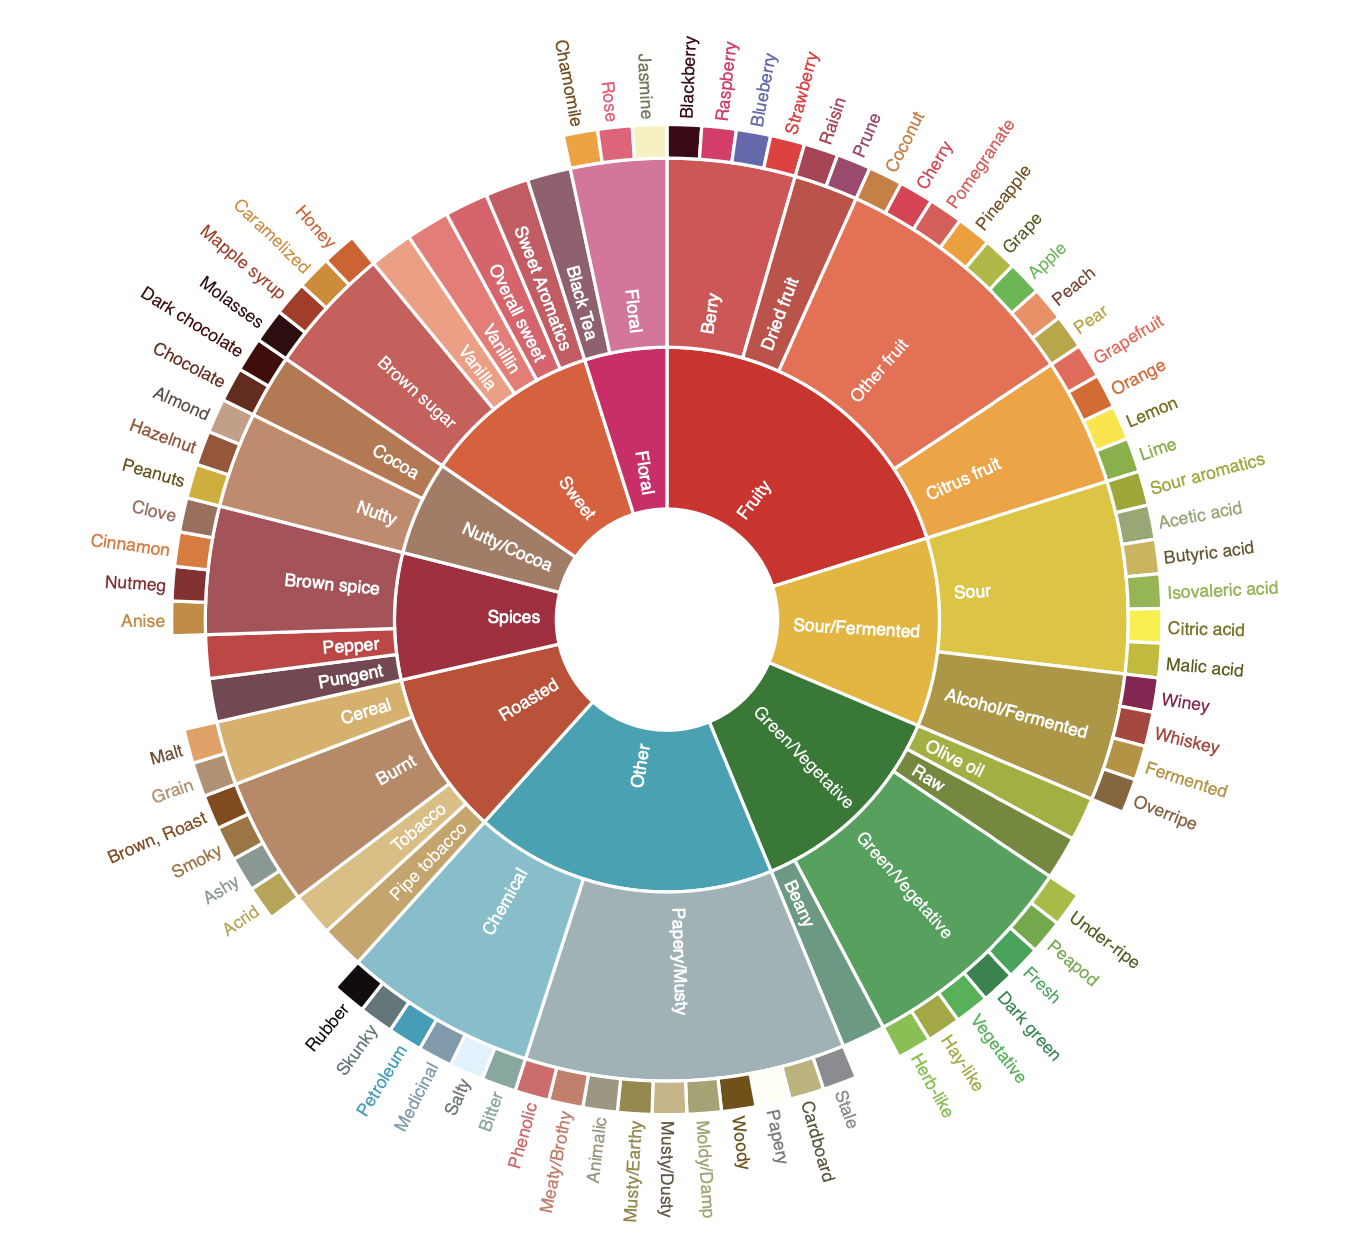
Each cup is scored on a 100-point scale, aggregated from 1–10 scores in the following dimensions:
- Aroma: Refers to the scent of ground coffee and brewed vapor. A strong, complex aroma with floral, fruity, or spicy notes, earns higher marks.
- Acidity: Describes brightness or vibrancy, not pH. Often described as “lively,” “sweet-tart,” or “crisp.” High acidity is prized in many origins (e.g., Ethiopian Yirgacheffe).
- Body: The tactile weight of coffee on the palate. Words like “syrupy,” “velvety,” or “light” reflect texture differences. 
Full-bodied coffees (e.g., Sumatran) score high.
- Flavor & Aftertaste: This combines all aspects of taste balance, sweetness, bitterness, clarity of flavor, and persistence. A lingering, clean aftertaste is essential for higher scores.

**Interpreting Coffee Review Scores**

| Score Range | Quality Description                                         |
|-------------|-------------------------------------------------------------|
| 97–100      | Exceptional and rare                                        |
| 93–96       | Distinctive, sweet-toned, structurally flawless             |
| 89–92       | High quality with personality or small quirks              |
| 85–88       | Solid and drinkable, but conventional                      |
| <85         | Commercial grade or unbalanced in structure/flavor         |

**Roast Level**

Roast profile significantly affects perceived acidity, aroma, and body:
- Light Roasts: preserve acidity and origin character but can taste underdeveloped.
- Medium Roasts: balance brightness and sweetness, often used for specialty beans.
- Dark Roasts: mute origin nuance in favor of bitter, smoky notes and heavier body.



**Dataset Source** 

the simplied version of Coffee Reviews Dataset from https://www.kaggle.com/datasets/schmoyote/coffee-reviews-dataset. This is an adaptation of Coffee_Data_CoffeeReview dataset by @hanifalirsyad. The data is created from coffee reviews(https://www.coffeereview.com) made between 2017-2022, and incudes information like countries of the roasteries, origins of the beans, roast type, prices, and reviews for each brand of coffee.


**Task**

We frame this as a regression problem: Predict the rating using both numeric and categorical features

Key aspects:
1. Predictors: kinds of coffee, roast level, price usd/100g, review_date and review.
2. Target: rating
	- Groups: Use ['name'] as group identifier to model non-IID data
	- Cross-validation: Ensure generalization to unseen countries using GroupShuffleSplit GroupKFold
	- Explainability: Analyze which features most influence predictions, using SHAP or permutation importance

**Challenges**
1. Non-IID structure: about 107 non-unique coffee in the dataset.
2. Missing values: attribute 'roast' contains 12 missing values.

**Problem Type**

- Supervised Regression
- Target: rating

**Goal**

Build a reproducible pipeline that:
- Handles preprocessing and missing data
- Uses group-aware validation
- Benchmarks multiple regressors
- Provides explainable predictions (SHAP, feature importances)
- Diagnoses performance across origins and error patterns

## 1. Data collection/manipulation

Import libraries for this dataset.

In [1]:
# libraries
import pandas as pd
import numpy as np
import random
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns

# machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
import shap
from sklearn.inspection import PartialDependenceDisplay
import pickle

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/simplified_coffee.csv')
print(df.shape)
df.head()

(1246, 9)


,name,roaster,roast,loc_country,origin,100g_USD,rating,review_date,review
0,Ethiopia Shakiso Mormora,Revel Coffee,Medium-Light,United States,Ethiopia,4.70,92,November 2017,"Crisply sweet, cocoa-toned. Lemon blossom, roa..."
1,Ethiopia Suke Quto,Roast House,Medium-Light,United States,Ethiopia,4.19,92,November 2017,"Delicate, sweetly spice-toned. Pink peppercorn..."
2,Ethiopia Gedeb Halo Beriti,Big Creek Coffee Roasters,Medium,United States,Ethiopia,4.85,94,November 2017,"Deeply sweet, subtly pungent. Honey, pear, tan..."
3,Ethiopia Kayon Mountain,Red Rooster Coffee Roaster,Light,United States,Ethiopia,5.14,93,November 2017,"Delicate, richly and sweetly tart. Dried hibis..."
4,Ethiopia Gelgelu Natural Organic,Willoughby's Coffee & Tea,Medium-Light,United States,Ethiopia,3.97,93,November 2017,"High-toned, floral. Dried apricot, magnolia, a..."


In [3]:
df.dtypes

name            object
roaster         object
roast           object
loc_country     object
origin          object
100g_USD       float64
rating           int64
review_date     object
review          object
dtype: object

In [4]:
df.describe(include='all')

,name,roaster,roast,loc_country,origin,100g_USD,rating,review_date,review
count,1246,1246,1234,1246,1246,1246.000000,1246.000000,1246,1246
unique,1142,300,5,12,27,NaN,NaN,61,1246
top,Ethiopia Kayon Mountain,Kakalove Cafe,Medium-Light,United States,Ethiopia,NaN,NaN,October 2020,"Crisply sweet, cocoa-toned. Lemon blossom, roa..."
freq,6,91,904,774,447,NaN,NaN,51,1
mean,NaN,NaN,NaN,NaN,NaN,10.479125,93.306581,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,13.486674,1.479413,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.170000,84.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,5.260000,93.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,6.170000,93.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,9.600000,94.000000,NaN,NaN


In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.isna().sum()

name            0
roaster         0
roast          12
loc_country     0
origin          0
100g_USD        0
rating          0
review_date     0
review          0
dtype: int64

## 2. Exploratory Data Analysis (EDA) 

**Categorical feature: name**

From the describe(), we found out that the feature 'name' is identical, so we would like to check it.

In [7]:
print(f'There are {df['name'].duplicated().sum()} non-unique coffee name.')
dup_coffee = df[df['name'].duplicated(keep=False)].sort_values('name')
dup_coffee.to_csv('duplicated_coffee_name.csv', index = False)
dup_coffee

There are 104 non-unique coffee name.


,name,roaster,roast,loc_country,origin,100g_USD,rating,review_date,review
29,100% Kona Bourbon Pointu Laurina,Hula Daddy Kona Coffee,Medium-Light,Hawai'i,Hawai'I,19.82,95,November 2017,"Sweet, deep, intense but balanced. Peach, mapl..."
220,100% Kona Bourbon Pointu Laurina,Hula Daddy Kona Coffee,Medium-Light,Hawai'i,Hawai'I,19.82,95,February 2019,"Delicately fruit-toned, richly cocoa-driven. R..."
396,100% Kona Bourbon Pointu Laurina,Hula Daddy Kona Coffee,Medium-Light,Hawai'i,Hawai'I,27.76,95,February 2020,Deeply and sweetly pungent; layered and intric...
922,100% Kona Bourbon Pointu Laurina,Hula Daddy Kona Coffee,Medium-Light,Hawai'i,Hawai'I,27.76,95,November 2021,"Richly aromatic, deeply sweet. Dark chocolate,..."
589,5a Poniente,El Gran Café,Medium-Dark,Guatemala,Guatemala,1.47,86,October 2020,"Chocolaty, sweetly smoky. Dark chocolate, scor..."
...,...,...,...,...,...,...,...,...,...
760,Suyusama Colombia,Bird Rock Coffee Roasters,Medium-Light,United States,Colombia,5.58,93,April 2021,"Chocolaty, sweetly nut-toned. Baking chocolate..."
456,Suyusama Colombia,Bird Rock Coffee Roasters,Medium-Light,United States,Colombia,5.58,93,June 2020,"Cocoa-toned, crisply sweet. Cocoa powder, haze..."
289,Suyusama Colombia,Bird Rock Coffee Roasters,Medium-Light,United States,Colombia,5.58,92,May 2019,Richly bittersweet with pleasing savory undert...
817,Yemen Mocha Haimi,Dragonfly Coffee Roasters,Light,United States,Yemen,15.43,94,July 2021,"Delicately perfumed, sweetly fermenty. Green g..."


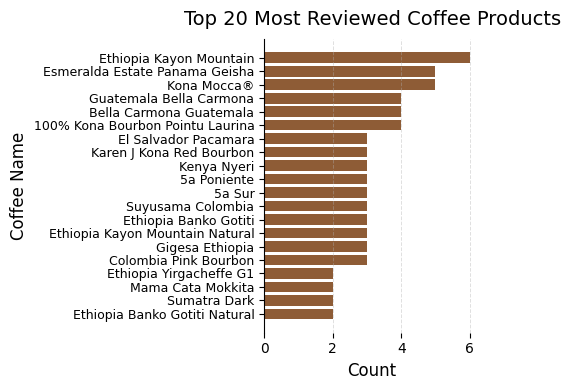

In [8]:
plt.figure(figsize=(5, 4))

top_varieties = (
    df['name']
    .value_counts()
    .nlargest(20)
    .sort_values(ascending=True)  
)

plt.barh(
    top_varieties.index,
    top_varieties.values,
    color="#8E5C36" 
)

plt.title('Top 20 Most Reviewed Coffee Products', fontsize=14, pad=10)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Coffee Name', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=9)
sns.despine(left=False, bottom=True)
plt.grid(axis="x", linestyle="--", linewidth=0.7, alpha=0.4)
plt.tight_layout()
plt.show()

We would like to take a look at the mean and std of the rating of these group coffee name.

In [9]:
df[df['name'].duplicated(keep=False)] \
  .sort_values('name') \
  .groupby('name')['rating'] \
  .agg(['count', 'mean', 'std']) \
  .query('std > 1') \
  .sort_values('std', ascending=False) \
  .head(20)

,count,mean,std
name,,,
Finca San Carlos,2,91.000000,4.242641
Ethiopia Guji,2,92.000000,2.828427
5a Poniente,3,88.333333,2.516611
5a Sur,3,88.666667,2.516611
Kona SL34,2,91.500000,2.121320
Kenya Kirinyaga Mukangu AB,2,93.500000,2.121320
Kenya,2,93.500000,2.121320
Ethiopia Yirgacheffe G1,2,92.500000,2.121320
Ethiopia Nano Genji,2,93.500000,2.121320


In [10]:
df[df['name'] == 'Finca San Carlos']

,name,roaster,roast,loc_country,origin,100g_USD,rating,review_date,review
583,Finca San Carlos,El Gran Café,Medium-Light,Guatemala,Guatemala,3.82,94,October 2020,"Richly sweet, nuanced, multi-layered. Apricot,..."
963,Finca San Carlos,El Gran Cafe,Light,Guatemala,Guatemala,3.82,88,December 2021,"Crisply sweet-savory. Pecan, pie cherry, brown..."


This is the same product from the same roaster, loc_country, origin, and price, but with different roast levels.  We can see that roast might be a critical factor driving the variation in ratings, since changes in roast can significantly alter the flavor profile, sweetness, acidity, and balance, leading to different reviewer perceptions.

In [11]:
df[df['name'] == 'Ethiopia Guji']

,name,roaster,roast,loc_country,origin,100g_USD,rating,review_date,review
171,Ethiopia Guji,North Coast Coffee Roasting,Medium-Light,United States,Ethiopia,4.76,90,November 2018,"Crisply sweet, balanced. Baker’s chocolate, ap..."
249,Ethiopia Guji,States Coffee & Mercantile,Medium-Light,United States,Ethiopia,5.29,94,March 2019,"Richly sweet, spice-toned. Star jasmine, mango..."


Interestingly, for ‘Ethiopia Guji’, the one with the second-highest std, the main difference is the roaster. We can infer that differences in roasting practice, technique, or house style between roasters may be responsible for the variation in ratings, even though the product name, origin, and roast level remain the same.

Here is a product that appears multiple times in the dataset. All of its features remain the same except the review date, suggesting that the differences in rating are likely due to changes in harvest year, batch quality, or reviewer perception over time rather than differences in product attributes.

In [12]:
df[df['name'] == '5a Sur']

,name,roaster,roast,loc_country,origin,100g_USD,rating,review_date,review
588,5a Sur,El Gran Café,Medium,Guatemala,Guatemala,1.47,86,October 2020,"Sweetly nut- and cocoa-toned. Hazelnut, cocoa ..."
964,5a Sur,El Gran Cafe,Medium,Guatemala,Guatemala,1.47,89,December 2021,"Crisply sweet, nut-toned. Cashew butter, bakin..."
1227,5a Sur,El Gran Cafe,Medium,Guatemala,Guatemala,1.47,91,November 2022,"Chocolate-toned, richly sweet-savory. Dark cho..."


In [13]:
from collections import Counter
fivea_sur_review = df[df['name'] == '5a Sur']['review']
text = ''.join(fivea_sur_review)
sur_words = text.split() 
Counter(sur_words).most_common()

[('and', 6),
 ('in', 3),
 ('aroma', 3),
 ('cup.', 3),
 ('mouthfeel.', 3),
 ('The', 3),
 ('finish', 3),
 ('Sweetly', 2),
 ('cocoa', 2),
 ('magnolia,', 2),
 ('cedar,', 2),
 ('structure', 2),
 ('with', 2),
 ('brisk', 2),
 ('acidity;', 2),
 ('of', 2),
 ('chocolate,', 2),
 ('cedar', 2),
 ('consolidates', 2),
 ('to', 2),
 ('nut-', 1),
 ('cocoa-toned.', 1),
 ('Hazelnut,', 1),
 ('powder,', 1),
 ('golden', 1),
 ('raisin', 1),
 ('Sweet', 1),
 ('velvety', 1),
 ('nut-toned', 1),
 ('is', 1),
 ('supported', 1),
 ('by', 1),
 ('hints', 1),
 ('powder', 1),
 ('cedar.', 1),
 ('Crisply', 1),
 ('sweet,', 1),
 ('nut-toned.', 1),
 ('Cashew', 1),
 ('butter,', 1),
 ('baking', 1),
 ('pear,', 1),
 ('structure;', 1),
 ('satiny', 1),
 ('notes', 1),
 ('cashew', 1),
 ('cedar.Chocolate-toned,', 1),
 ('richly', 1),
 ('sweet-savory.', 1),
 ('Dark', 1),
 ('nasturtium,', 1),
 ('black', 1),
 ('ucherry,', 1),
 ('agave', 1),
 ('syrup', 1),
 ('Bittersweet', 1),
 ('gentle,', 1),
 ('rounded', 1),
 ('plush,', 1),
 ('syrupy', 1)

From the duplicated-name table showed above, we find that many coffees appear multiple times in the dataset with different features. This means that the column 'name' identifies the same physical product across multiple evaluations. Therefore, **name behaves as a grouping variable**.

Other columns like roaster, loc_country, and origin are categorical descriptors, not grouping keys. They describe properties of the coffee but do not uniquely identify individual products and therefore should remain as normal predictive features, not group identifiers.

From above, we find that the same coffee (5a Sur) receives different ratings across review dates, even though the roaster, origin, and roast level remain constant. This variation reflects reviewer subjectivity and temporal factors rather than product inconsistency. The word-frequency summary shows stable sensory themes: cedar, aroma, cup structure, mouthfeel, sweet notes, cocoa/chocolate, and nutty descriptors appear repeatedly. Overall, 5a Sur is consistently characterized as a sweet-toned, cocoa-forward, nut-accented Guatemalan profile, and the reviews differ only in nuance rather than substance, the linguistic feature are relatively stable, which support a fair generalizaiton.

**Categorical feature: Roasters**

/var/folders/rs/40grxw_n255bd354zxdw3rbw0000gn/T/ipykernel_98739/1091201593.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


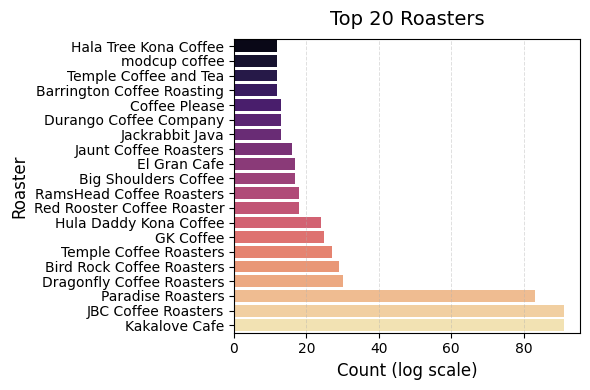

In [14]:
plt.figure(figsize=(6, 4))
roaster = df['roaster'].value_counts().nlargest(20).sort_values()

sns.barplot(
    x=roaster.values,
    y=roaster.index,
    palette='magma',
    linewidth=0.5
)

plt.title('Top 20 Roasters', fontsize=14, pad=10)
plt.xlabel('Count (log scale)', fontsize=12)
plt.ylabel('Roaster', fontsize=12)
plt.grid(axis='x', linestyle='--', linewidth=0.7, alpha=0.4)
plt.tight_layout()
plt.show()

/var/folders/rs/40grxw_n255bd354zxdw3rbw0000gn/T/ipykernel_98739/2091179433.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


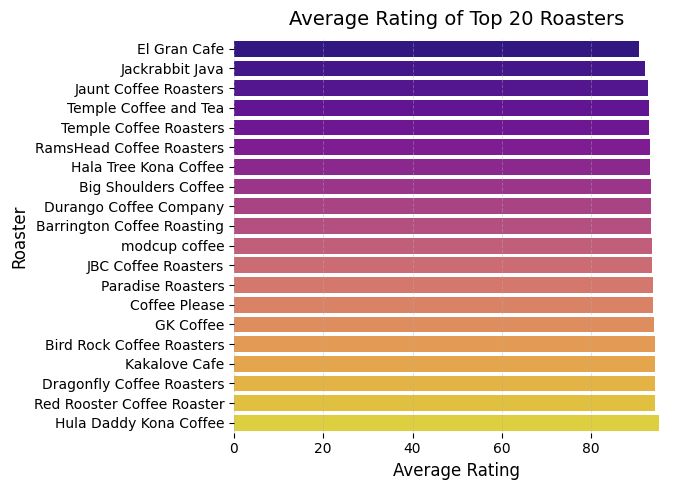

In [15]:
top_roasters = df['roaster'].value_counts().nlargest(20).index

roaster_avg = (
    df[df['roaster'].isin(top_roasters)]
      .groupby('roaster')['rating']
      .mean()
      .sort_values()
)

plt.figure(figsize=(7, 5))

sns.barplot(
    x=roaster_avg.values,
    y=roaster_avg.index,
    palette='plasma',
    linewidth=0.5,
)

plt.title('Average Rating of Top 20 Roasters', fontsize=14, pad=10)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Roaster', fontsize=12)

plt.grid(axis='x', linestyle='--', linewidth=0.7, alpha=0.4)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

The top 20 roasters by number of coffees reviewed show a wide range of activity levels but a relatively narrow band of average ratings (89–93). Larger roasters such as Kakalove Cafe and JBC Coffee Roasters have the highest submission counts but do not necessarily lead in average rating. Conversely, some smaller roasters with fewer products (e.g., El Gran Cafe, Jackrabbit Java) achieve slightly higher average scores. We find out that the top roasters does not show strong and relatively consistent quality, with modest variation in mean ratings.

**Categorical feature: roast**

In [16]:
print(df['roast'].unique())
df.groupby('roast')['rating'].agg(['count', 'mean', 'std']).sort_values('count', ascending=False)

['Medium-Light' 'Medium' 'Light' 'Medium-Dark' nan 'Dark']


,count,mean,std
roast,,,
Medium-Light,904,93.366150,1.329370
Light,198,93.555556,1.502771
Medium,114,92.543860,1.829649
Medium-Dark,15,92.333333,3.244042
Dark,3,90.333333,3.511885


We found out that light and Medium-Light roasts score highest and most consistently. Dark and Medium-Dark roasts show lower ratings and much higher volatility, very likely to be caused by few samples. Medium roast sits exactly between these two worlds, both in score and consistency. The rating trend generally declines as the roast level becomes darker.

/var/folders/rs/40grxw_n255bd354zxdw3rbw0000gn/T/ipykernel_98739/424260969.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


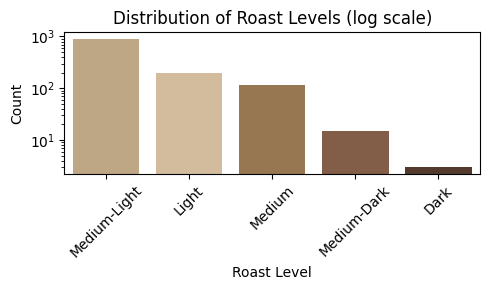

In [17]:
roast_palette = [
    "#C7A97C", 
    "#DBBD94",
    "#A27647", 
    "#8C5B3E",  
    "#5A3825",  
]
plt.figure(figsize=(5, 3))
sns.countplot(
                data = df,
                x ='roast',
                order = df['roast'].value_counts().index,
                palette = roast_palette,
                legend=False,
)

plt.yscale('log')
plt.xticks(rotation=45)
plt.title('Distribution of Roast Levels (log scale)')
plt.xlabel('Roast Level')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('distribution_of_roast_level.jpg', dpi=300)
plt.show()

/var/folders/rs/40grxw_n255bd354zxdw3rbw0000gn/T/ipykernel_98739/204453552.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


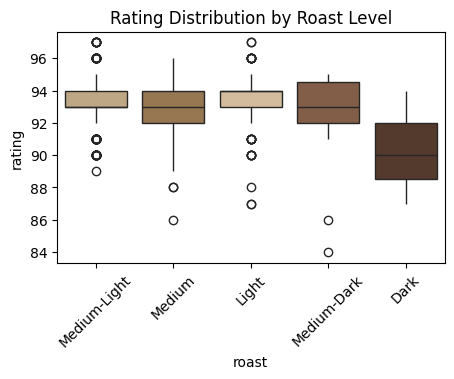

In [18]:
roast_palette = [
    "#C7A97C",
    "#A27647",  
    "#DBBD94",
    "#8C5B3E",  
    "#5A3825",  
]

plt.figure(figsize=(5,3))
sns.boxplot(
            data=df,
            x='roast',
            y='rating',
            palette=roast_palette,
            showcaps=False
)
plt.xticks(rotation=45)
plt.title('Rating Distribution by Roast Level')
plt.show()

The roast distribution is highly imbalanced, with Medium-Light being the most common and Dark roast represented by only 3 samples. As a result, the rating distributions for Light, Medium-Light, and Medium roasts are informative and show tight clustering around 92–95, we found out that lighter roasts tend to receive consistently higher ratings. Medium roasts display slightly greater variability but maintain similarly high medians. In contrast, the distributions for Medium-Dark and especially Dark roasts are not reliable due to their limited sample sizes, therefore, no meaningful conclusions can be drawn about their rating tendencies.

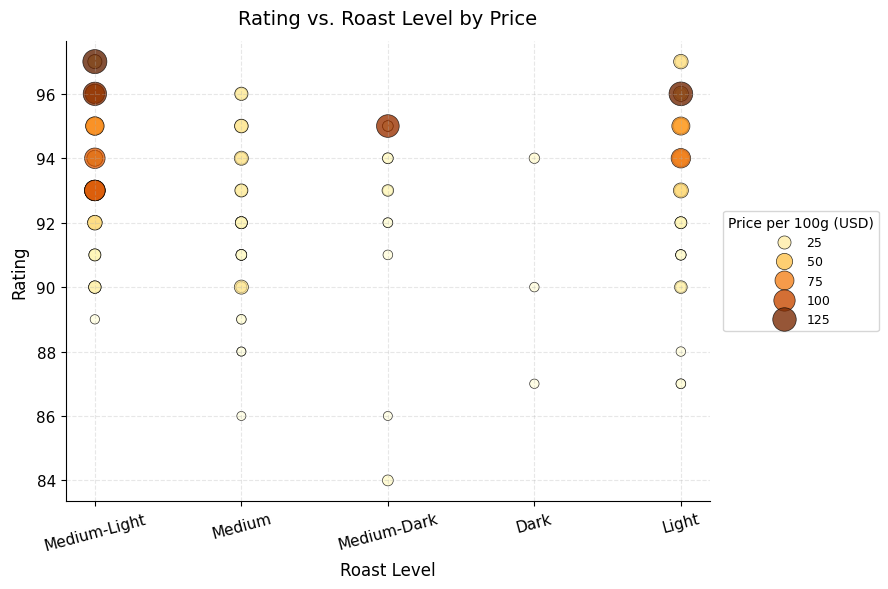

In [19]:
plt.figure(figsize=(9, 6))
df_sorted = df.sort_values('100g_USD')

ax = sns.scatterplot(
    data=df_sorted,
    x='roast',
    y='rating',
    hue='100g_USD',
    size='100g_USD',
    sizes=(40, 300),
    palette='YlOrBr',
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5,
)

plt.xticks(fontsize=11, rotation=15)
plt.yticks(fontsize=11)
plt.xlabel("Roast Level", fontsize=12, labelpad=6)
plt.ylabel("Rating", fontsize=12, labelpad=6)
plt.title("Rating vs. Roast Level by Price", fontsize=14, pad=12)

handles, labels = ax.get_legend_handles_labels()
# legend order to separate hue and size better
new_labels = ['25', '50', '75', '100', '125']
new_sizes = [25, 50, 75, 100, 125]
legend = ax.legend(
    title='Price per 100g (USD)',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0,
    title_fontsize=10,
    fontsize=9
)

plt.grid(True, linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.savefig('rating_vs_roastlevel.jpg', dpi=300)
plt.show()

From the figure, we can see that roast level, rating, and price reveals distinct segmentation within the specialty coffee market. Medium-Light and Light roasts occupy the premium end, both have  the highest ratings and the broadest price dispersion, including numerous high-value micro-lot and competition coffees that exceed $100 per 100g. Medium roasts form a stable mid-market cluster, characterized by moderate pricing and consistently high—though less extreme—ratings. Medium-Dark roasts show slightly elevated prices relative to Medium, driven primarily by a few expensive but sparse observations rather than a systematic pattern. Dark roasts remain the most uniform category, with tightly clustered low prices and limited rating variability, reflecting their positioning toward mainstream and commodity-leaning products. Higher prices and higher ratings concentrate in lighter roast styles, suggesting that premium-quality beans are most often marketed through lighter roasting.

**Categorical feature: loc_country(Location of the roaster)**

/var/folders/rs/40grxw_n255bd354zxdw3rbw0000gn/T/ipykernel_98739/4097014272.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


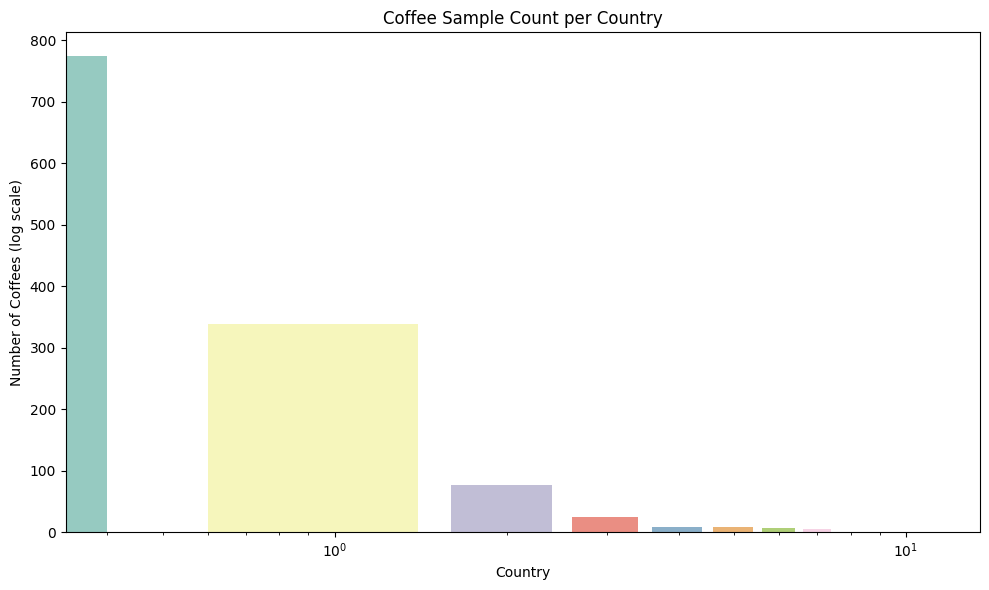

In [20]:
plt.figure(figsize=(10, 6))

country_counts = df['loc_country'].value_counts()

sns.barplot(
            y = country_counts.values,
            x = country_counts.index,
            palette = 'Set3'
)

plt.ylabel('Number of Coffees (log scale)')
plt.xlabel('Country')
plt.xscale('log') 
plt.title('Coffee Sample Count per Country')
plt.tight_layout()
plt.show()

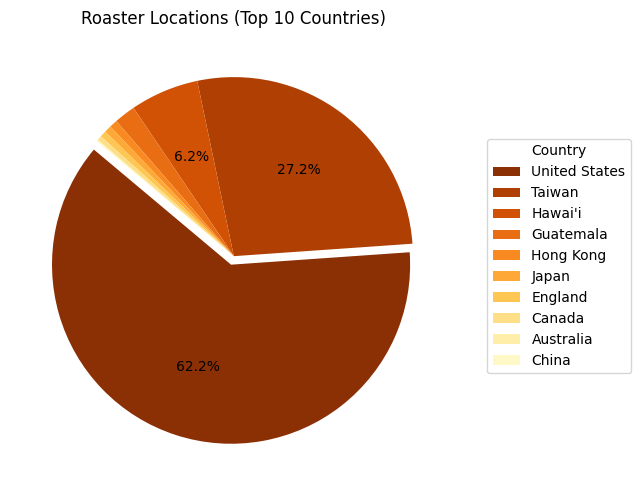

In [21]:
plt.figure(figsize=(8, 5))

loc_counts = df['loc_country'].value_counts().head(10)

plt.pie(
        loc_counts.values,
        labels=None,                 
        autopct=lambda p: f'{p:.1f}%' if p > 5 else '', 
        startangle=140,
        explode=[0.05] + [0]*9,     
        colors=sns.color_palette('YlOrBr_r', 10),

)

plt.legend(
            loc_counts.index,
            title='Country',
            bbox_to_anchor=(1.05, 0.5),
            loc='center left'
)

plt.title('Roaster Locations (Top 10 Countries)')
plt.tight_layout()
plt.show()

The majority of the roasteries  are based in the United States and Taiwan. The data comes from the website based in the U.S., most roasters submit coffees for scoring are the U.S. specialty roaster and Asian roasters with strong speciatly scenes, especially Taiwan, we saw that the top roaster Kakalove is located in Taiwan. The dataset is inherently biased toward regions with high specialty-coffee engagement and strong participation in international review platforms.

In [22]:
df.groupby('loc_country')['rating'].agg(['count','mean','std']).sort_values('mean', ascending=False)

,count,mean,std
loc_country,,,
Australia,1,96.000000,NaN
England,7,94.142857,0.899735
Kenya,1,94.000000,NaN
Taiwan,338,93.639053,1.210690
Canada,5,93.600000,0.894427
Hawai'i,77,93.415584,1.935477
United States,774,93.245478,1.387133
New Taiwan,1,93.000000,NaN
Hong Kong,9,92.666667,1.224745


The average rating by country appears misleading at first glance because the sample sizes are extremely imbalanced. The United States and Taiwan dominate the dataset—together they contribute more than 80% of all entries—so their mean ratings reflect broad, diverse submissions rather than specific country-level effects. Countries with only a few samples (e.g., Australia, Kenya, China, New Taiwan) show artificially high or low averages simply because the sample size is too small to generalize. When considering stability (std), England exhibits a low standard deviation, but this is based on only seven data points and should not be overinterpreted. The variability patterns suggest that country should not be treated as a strong independent predictor of rating, as the observed differences are driven more by sample imbalance than by true country-specific effects.

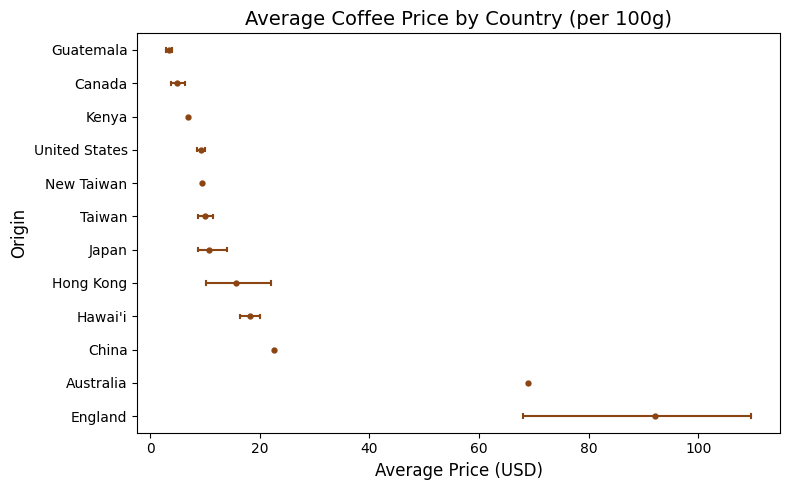

In [23]:
sorted_origins = df.groupby('loc_country')['100g_USD'].mean().sort_values().index

plt.figure(figsize=(8, 5))
sns.pointplot(
            data = df,
            y ='loc_country',
            x ='100g_USD',
            order =sorted_origins,
            estimator = 'mean',
            capsize=0.1,
            color ='saddlebrown',
            err_kws = {'linewidth': 1.5},
            linestyles='none',
            markers = 'o',
            markersize = 2.5
)

plt.title('Average Coffee Price by Country (per 100g)', fontsize=14)
plt.xlabel('Average Price (USD)', fontsize=12)
plt.ylabel('Origin', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

The two most expensive one are not very suprising as they have they highest average rating, however the relationship between the country the roaster from, the price and the rating are not linear, for example, China, Hawai‘i, and Hong Kong all show elevated average prices, but their ratings diverge. Hawai‘i maintains both high price and high quality, while China and Hong Kong have high prices without matching ratings, suggesting pricing may be driven more by local market conditions, branding, or consumer preferences than by actual cup quality.

**Categorical feature: Origin(origin of beans)**

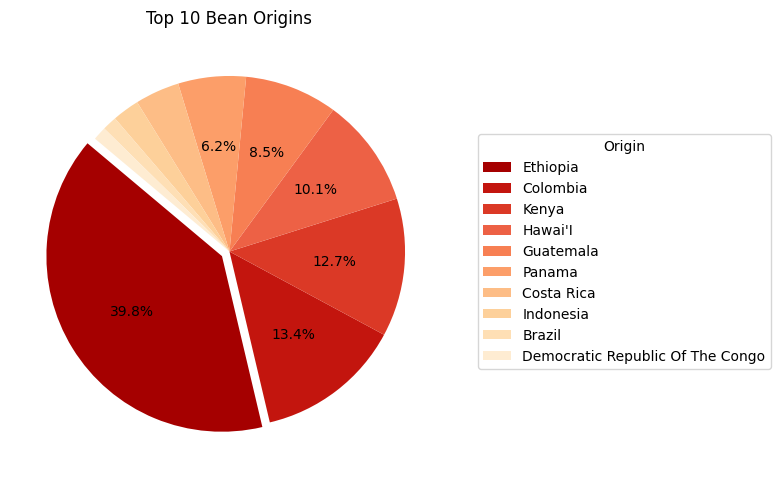

In [24]:
plt.figure(figsize=(8, 10))

origin_counts = df['origin'].value_counts().head(10)

plt.pie(
        origin_counts.values,
        labels=None,                 
        autopct=lambda p: f'{p:.1f}%' if p > 5 else '', 
        startangle=140,
        explode=[0.05] + [0]*9,     
        colors=sns.color_palette('OrRd_r', 10),

)

plt.legend(
            origin_counts.index,
            title='Origin',
            bbox_to_anchor=(1.05, 0.5),
            loc='center left'
)

plt.title('Top 10 Bean Origins')
plt.tight_layout()
plt.savefig('Top10_Bean_origins.jpg', dpi=300)
plt.show()

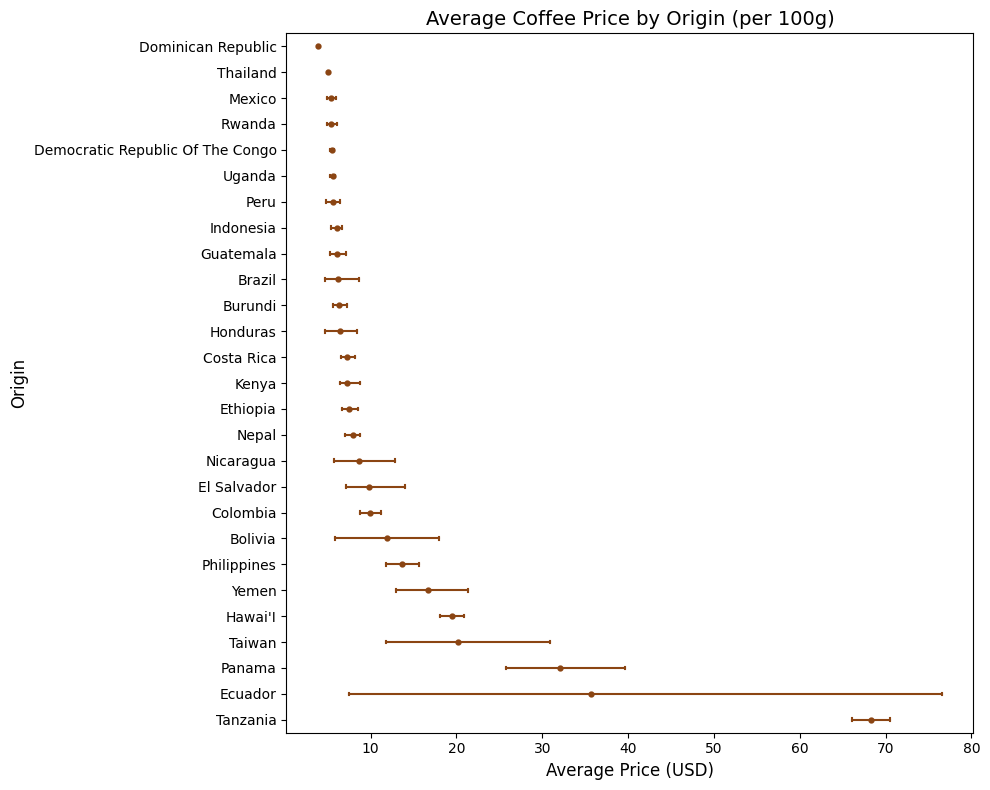

In [25]:
sorted_origins = df.groupby('origin')['100g_USD'].mean().sort_values().index

plt.figure(figsize=(10, 8))
sns.pointplot(
            data = df,
            y ='origin',
            x ='100g_USD',
            order =sorted_origins,
            estimator = 'mean',
            capsize=0.1,
            color ='saddlebrown',
            err_kws = {'linewidth': 1.5},
            linestyles='none',
            markers = 'o',
            markersize = 2.5
)

plt.title('Average Coffee Price by Origin (per 100g)', fontsize=14)
plt.xlabel('Average Price (USD)', fontsize=12)
plt.ylabel('Origin', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

This plot shows the average coffee price per 100g across different origins, we can see the substantial discrepancies in pricing. Origins like <u>Tanzania, Ecuador, Panama, and Taiwan</u> have higher average prices, with wide error bars indicating high variance—suggesting premium or niche products driving up the mean. 

Originss such as Dominican Republic, Thailand, Mexico, Rwanda, Congo, Peru, Indonesia have lower prices with minimal variation, possibly reflecting more standardized offerings or cost-effective production. Interestingly,  Ethiopia, despite being the most represented origin and the historical epicenter of specialty coffee, maintains an unexpectedly modest average price below $10 per 100g. This anomaly is particularly striking given that several of the highest-rated coffees originate from Ethiopia, pointing to potential underpricing or undervaluation in global markets. Yemen, though priced above average, also show large standard deviations, indicating diverse pricing strategies or product tiers. These pricing patterns could reflect differences in processing methods, market targeting, export orientation, or brand perception factors that should be examined alongside rating and roast level for comprehensive modeling.

**Numerical feature: rating**

Most ratings are tightly clustered between 84 and 94, confirming a narrow score band (common in specialty coffee reviews).

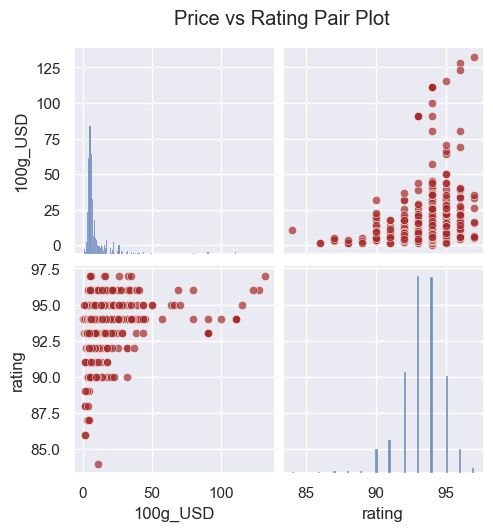

In [26]:
sns.set(style="darkgrid")
sns.pairplot(df, vars=["100g_USD", "rating"], kind='scatter', plot_kws={"color": "brown", "alpha": 0.7})

plt.suptitle("Price vs Rating Pair Plot", x=0.57, y=1.05)
plt.savefig('price_rating_pair.jpg', dpi = 300)
plt.show()

As expected, higher-rated specialty coffees tend to be more expensive, but the relationship is not strictly linear. From the upper-right scatter plot, we observe that nearly all coffees rated between 85 and 90 are priced below $10 per 100g, with very few exceptions. 

Coffees rated above 90 span a much wider price range—approximately $5-45 indicating that many mid-to-high quality coffees remain affordably priced. However, there is a noticeable concentration of coffees rated between 90 and 95 priced in the $60–$120 range, this is a premium tier. 

The top three rated coffees—those near or above 96—are priced over $120 per 100g, likely representing rare or exceptional offerings. This pattern suggests that while high price can be associated with quality, excellent ratings are still attainable at moderate price levels, which is important context for predictive modeling.

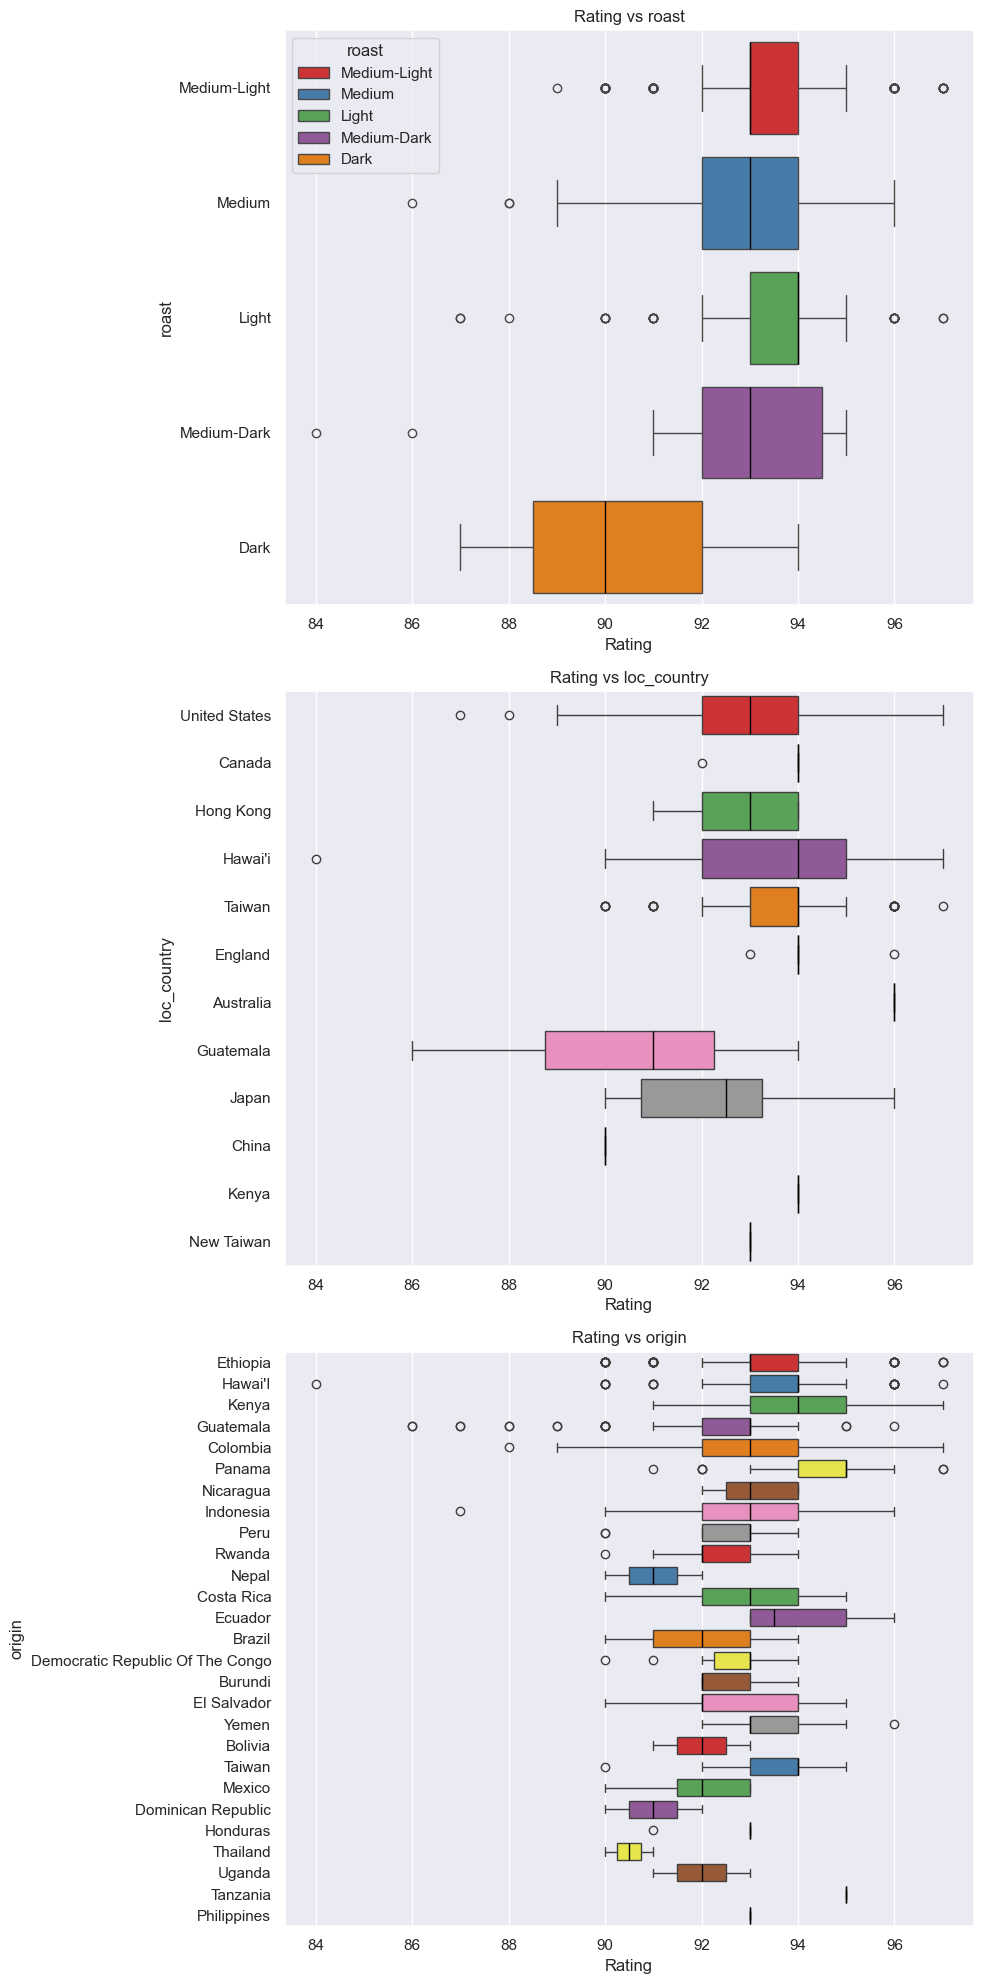

In [27]:
features = ['roast', 'loc_country', 'origin']

plt.figure(figsize=(10,20))

for i, col in enumerate(features, 1):
    plt.subplot(3,1,i)
    sns.boxplot(data=df, y=col, x='rating', palette='Set1',hue=col, medianprops={'color': 'black', 'linewidth': 1})
    plt.title(f'Rating vs {col}', fontsize = 12)
    plt.ylabel(col, fontsize=12)
    plt.xlabel('Rating', fontsize = 12)

plt.tight_layout()
plt.savefig('summary.jpg', dpi =300)
plt.show()

In [28]:
df.groupby('origin')['rating'].agg(['count','mean','median', 'std']).sort_values('mean', ascending=False)

,count,mean,median,std
origin,,,,
Tanzania,2,95.000000,95.0,0.000000
Panama,70,94.500000,95.0,1.151558
Ecuador,8,94.000000,93.5,1.195229
Kenya,143,93.874126,94.0,1.174057
Yemen,13,93.615385,93.0,1.043908
Hawai'I,113,93.451327,94.0,1.721664
Ethiopia,447,93.449664,93.0,1.262265
Taiwan,9,93.444444,94.0,1.589899
Colombia,151,93.172185,93.0,1.513326


The origin of coffee emerges as a strong categorical predictor for rating, with several countries Panama, Kenya, Ethiopia, Colombia, demonstrating high average scores, sufficient sample sizes, and relatively low variance making them statistically robust features for modeling. However, some origins exhibit high variability like Guatemala, Indonesia or sparse representation like Tanzania, Nepal, suggesting a need for careful encoding—such as target or leave-one-out encoding—to avoid overfitting. For tree-based models like Random Forest or XGBoost, origin should be retained as a key variable, potentially grouped or clustered to reduce noise, while also considering interaction effects with features like roaster or roast level to capture nuanced patterns in specialty coffee rating prediction.

## 3. Feature Engineering

### 3.1 Text Data Preprocessing

The feature 'review' is unstructured, to refine for our ML algorithm, we process it with transferring all the text into lowercase, and move the non-alphabetical characters, keeping only letters in english. Then, we use tokenizaiton and lemmtization from the NLTK library. 

**Tokenizaiton**(https://docs.python.org/3/library/tokenize.html) basically just split the text in the review into tokens. 

**Lemmatization** reduces different word variations to a single, canonical root (lemma)., for example, 'tasting' will be reduced to 'taste'. The reason behind this is because, if we input the feature to TF-IDF without lemmatization, we might input ['taste', 'tastes', 'tasting', 'tasted',...] all these words become different columns in the TF-IDF matrix, this inflating the dimensionality and makes the model more sparse, harder to generalize, and more prone to overfitting. With lemmatizaiton, we have better signal-to-noise ratio and more efficient.

see https://www.nltk.org/api/nltk.stem.wordnet.html

Also, here we will remove the stop words like and/or/with... via NLTK's stopwords to better capture the accuracy and reduce noise, those stop words is irrelevant with our coffee review. 

In [50]:
txt_before_prep = df['review']
review_length = txt_before_prep.str.len()   
review_word_length = txt_before_prep.str.split().str.len()  

In [51]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_review(t):
    t = t.lower()
    t = re.sub(r'[^a-z\s]', '', t)
            
    words = t.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

df['review'] = df['review'].apply(clean_review)
df['review']

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lilylai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lilylai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0       crisply sweet cocoatoned lemon blossom roasted...
1       delicate sweetly spicetoned pink peppercorn da...
2       deeply sweet subtly pungent honey pear tangeri...
3       delicate richly sweetly tart dried hibiscus fi...
4       hightoned floral dried apricot magnolia almond...
                              ...                        
1241    crisply sweet nuttoned almond brittle pie cher...
1242    chocolaty floralframed cocoa nib honeysuckle d...
1243    hightoned enticingly sweet black cherry narcis...
1244    vibrantly sweet subtly nuanced apricot dark ch...
1245    evaluated espresso multilayered complex dark c...
Name: review, Length: 1246, dtype: object

In [68]:
pd.concat([txt_before_prep.rename('review before extraction'), 
           review_word_length.rename('len_chars(before)'),
           df['review'].rename('review after extraction'), 
           df['review'].str.split().str.len().rename('len_chars(after)')], axis=1)

,review before extraction,len_chars(before),review after extraction,len_chars(after)
0,"Crisply sweet, cocoa-toned. Lemon blossom, roa...",46,crisply sweet cocoatoned lemon blossom roasted...,35
1,"Delicate, sweetly spice-toned. Pink peppercorn...",36,delicate sweetly spicetoned pink peppercorn da...,30
2,"Deeply sweet, subtly pungent. Honey, pear, tan...",48,deeply sweet subtly pungent honey pear tangeri...,35
3,"Delicate, richly and sweetly tart. Dried hibis...",40,delicate richly sweetly tart dried hibiscus fi...,32
4,"High-toned, floral. Dried apricot, magnolia, a...",45,hightoned floral dried apricot magnolia almond...,33
...,...,...,...,...
1241,"Crisply sweet, nut-toned. Almond brittle, pie ...",35,crisply sweet nuttoned almond brittle pie cher...,27
1242,"Chocolaty, floral-framed. Cocoa nib, honeysuck...",32,chocolaty floralframed cocoa nib honeysuckle d...,25
1243,"High-toned, enticingly sweet. Black cherry, na...",42,hightoned enticingly sweet black cherry narcis...,32
1244,"Vibrantly sweet, subtly nuanced. Apricot, dar...",34,vibrantly sweet subtly nuanced apricot dark ch...,26


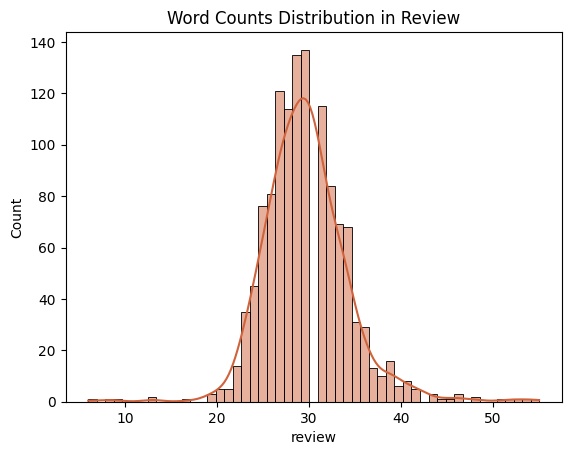

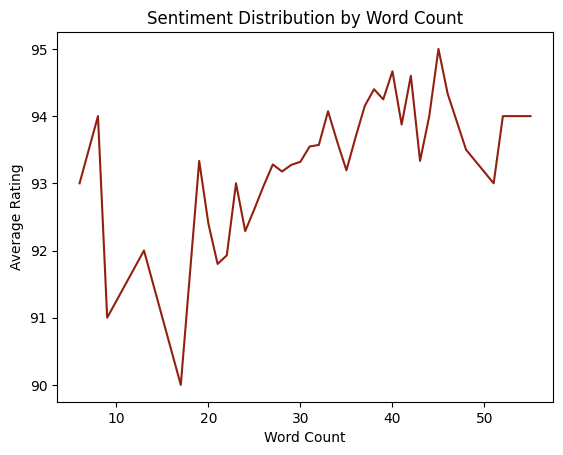

In [53]:
word_count = df['review'].apply(lambda x: len(x.split()))
sns.histplot(word_count, kde=True, color="#D0633C")
plt.title('Word Counts Distribution in Review')
plt.show()

df.groupby(df['review'].str.split().apply(len))['rating'].mean().plot(color = "#922011")
plt.title('Sentiment Distribution by Word Count')
plt.xlabel('Word Count')
plt.ylabel('Average Rating')
plt.show()

The second plot aggregates ratings by word count, producing a smoothed trend of average rating as a function of review length. Despite some local fluctuations—mainly caused by word counts with few observations—the overall pattern shows a weak, upward-sloping trend:

- Short reviews (<15 words) tend to correspond to ratings near 91–92.
- Medium-length reviews (~25–35 words) cluster around 93–94.
- Some of the highest ratings (94–95) appear in reviews with ~35–40 words.

However, the effect size is modest. The variance in rating across word counts is much smaller than the typical year-to-year price variation observed earlier. In addition, rating increases do not scale linearly with word count, the curve is irregular, and local peaks occur at multiple points. Thus, the evidence suggests that review length is not a primary driver of rating. Instead, the small positive association likely reflects the fact that coffees receiving higher evaluations tend to have slightly more descriptive reviews, rather than more words per se. This reinforces the idea that ratings reflect quality assessments, while review length reflects editorial consistency with minor quality-dependent elaboration.


### 3.2 Feature Extraction
We will apply 'TF-IDF (Term Frequency - Inverse Document Frequency)' to the text feature 'review' in below's pipleline.

### 3.3 Numerical Feature Extraction

In the original dataset, the 'review_date' feature is formatted as strings like "May 2017" or "April 2018". While this format is human-readable, it is not directly usable by machine learning models, which typically require numerical inputs. To address this, we convert it to datetime format.

This allows the model to capture temporal patterns or trends, such as shifts in coffee pricing, rating criteria, or sourcing preferences over time. For example, specialty coffees may become more expensive or receive higher ratings in more recent years, and this temporal trend can improve model accuracy. Moreover, converting to numeric values ensures compatibility with standard preprocessing pipelines, particularly for algorithms that do not handle date or string formats natively (e.g., XGBoost, Logistic Regression).

In [3]:
df['review_date'] = pd.to_datetime(df['review_date'])

/var/folders/rs/40grxw_n255bd354zxdw3rbw0000gn/T/ipykernel_61952/3780563355.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['review_date'] = pd.to_datetime(df['review_date'])


In [4]:
df[['review_date']]

,review_date
0,2017-11-01
1,2017-11-01
2,2017-11-01
3,2017-11-01
4,2017-11-01
...,...
1241,2022-11-01
1242,2022-11-01
1243,2022-11-01
1244,2022-11-01


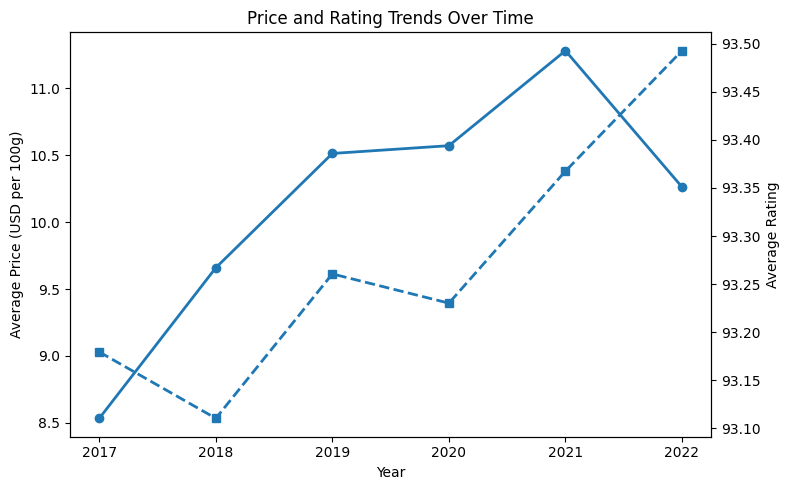

In [5]:
yearly = (
    df.groupby(df['review_date'].dt.year)
      .agg(
          avg_price=('100g_USD', 'mean'),
          avg_rating=('rating', 'mean')
      )
)

fig, axes = plt.subplots(figsize=(8,5))

axes.plot(yearly.index, yearly['avg_price'], marker='o', linewidth=2)
axes.set_xlabel('Year')
axes.set_ylabel('Average Price (USD per 100g)')

ax2 = axes.twinx()
ax2.plot(yearly.index, yearly['avg_rating'], marker='s', linestyle='--', linewidth=2)
ax2.set_ylabel('Average Rating')

plt.title('Price and Rating Trends Over Time')
plt.tight_layout()
plt.savefig('price_rating_trends.jpg', dpi=300)
plt.show()

- Price Trend: average price shows a strong upward trajectory from 2017 through 2021, rising from roughly 8.5 USD/100g to a peak near 11.7 USD/100g. This is followed by a notable decline in 2022, likely driven by global supply pressures and rising specialty-market demand, culminating in a peak and subsequent correction. The amplitude of these movements shows that price is highly sensitive to market conditions rather than to changes in review composition.

- Rating Trend:  the rating series displays minimal variance and only a weak upward tendency. Ratings remain in a narrow band (~93.1–93.5), with a mild dip around 2018 and a gradual increase from 2019 to 2022. The magnitude of these yearly shifts is small relative to the price changes, suggesting that ratings are stable, tightly distributed, and largely insulated from short-term market shifts. Probably rating standard appear more consistent in recent year, and more nice specailty beans produced. 

## 4. Methodology

### 4.1 Data Splitting and Preprocessing

In [6]:
df.columns

Index(['name', 'roaster', 'roast', 'loc_country', 'origin', '100g_USD',
       'rating', 'review_date', 'review'],
      dtype='object')

From former analysis, we found out this dataset is non-iid, the group feature is 'name' which is the name of the specialty coffee. Our target goal is to predict the rating of the specialty coffee, so y should be 'rating'. Because the dataset contains strong group structure (multiple reviews for the same coffee product), standard K-fold would leak information across folds. We therefore use a nested cross-validation scheme: an outer GroupShuffleSplit to create unbiased test partitions, and an inner GroupKFold for hyperparameter optimization. This approach is standard for grouped non-IID data and ensures that neither model selection nor evaluation is contaminated by shared group membership.

For missing value in the categorical feature 'roast', we will apply SimpleImputer() to fill the NaN value with 'unknown'. For text feature, 'review', we will do max_features = 500 and choose the ngram_range = (1-2).

In [7]:
X = df.drop(columns=['name', 'rating']) 
y = df['rating']
groups = df['name']

num_features = ['100g_USD']
cat_features = ['roaster', 'roast', 'loc_country', 'origin','review_date']
text_feature = 'review'

num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
                                  ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])
text_transformer = Pipeline(steps=[('txt', TfidfVectorizer(max_features=500, ngram_range=(1,2), stop_words='english'))])
preprocessor = ColumnTransformer(
                transformers=[
                    ('num', num_transformer, num_features),
                    ('cat', cat_transformer, cat_features),
                    ('txt', text_transformer, text_feature)
                ]
            )

### 4.2 Machine Learning Pipeline 

In [8]:
def ML_pipeline(X, y, groups, ML_algo, param_grid):
    test_rmses = []
    cv_rmses = []
    best_params = []
    best_models = []
    baseline_rmses = []

    for i in range(10):
        gss = GroupShuffleSplit(n_splits=4, train_size=0.8, random_state=42+i)
        print(f"\n=== Iter {i+1} ===")
        for split_idx, (other_idx, test_idx) in enumerate(gss.split(X,y,groups)):
            print(f'    -- Split {split_idx+1} --')
            X_other, y_other = X.iloc[other_idx], y.iloc[other_idx]
            X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
            groups_other = groups.iloc[other_idx]

            # baseline cal
            base_pred =np.full(len(y_test), y_other.mean())
            baseline_rmse = root_mean_squared_error(y_test,base_pred)
            baseline_rmses.append(baseline_rmse)

            gkf = GroupKFold(n_splits=3)
            
            model = make_pipeline(preprocessor, ML_algo)

            grid = GridSearchCV(estimator=model,
                                param_grid=param_grid,
                                scoring='neg_root_mean_squared_error',
                                cv=gkf,
                                verbose=1,
                                n_jobs=-1,
                                error_score='raise')
            
            grid.fit(X_other, y_other, groups=groups_other)
            best_model = grid.best_estimator_
            best_models.append(best_model)
            cv_rmse = -grid.best_score_
            cv_rmses.append(cv_rmse)
            best_param = grid.best_params_
            best_params.append(best_param)

            print(f'        Baseline RMSE: {baseline_rmse:.4f}')
            print(f'        Best Params:{best_param}')
            print(f'        Best Inner-CV RMSE: {cv_rmse:.4f}')


            y_test_pred = best_model.predict(X_test)
            test_rmse = root_mean_squared_error(y_test, y_test_pred)
            test_rmses.append(test_rmse)
            print(f'        Test RMSE: {test_rmse:.4f}')

    print('\nFinal Summary:')
    print(f'    Mean Baseline RMSE: {np.mean(baseline_rmses):.4f} ± {np.std(baseline_rmses):.4f}')
    print(f'    Mean Test RMSE: {np.mean(test_rmses):.4f}')
    print(f'    Std Test RMSE: {np.std(test_rmses):.4f}')
    baseline_improvement = ((np.mean(baseline_rmses) - np.mean(test_rmses)) / np.mean(baseline_rmses)) * 100
    print(f'    Avg improvement over baseline: {baseline_improvement:.4f}%')
    
    return {
            'test_rmses': test_rmses,
            'cv_rmses': cv_rmses,
            'best_params': best_params,
            'best_models': best_models,
            'baseline_rmses': baseline_rmses,
            'baseline_improvement_pct': baseline_improvement
    }

### 4.3 Training

In [9]:
models_results = {}

**1. Ridge()**

In [10]:
param_grid_ridge = {'ridge__alpha': np.logspace(-3,3,7),
              'ridge__max_iter': [1000]}
ridge = Ridge()
models_results['Ridge'] = ML_pipeline(X, y, groups= groups, ML_algo= ridge, param_grid = param_grid_ridge)
best_ridge_model = models_results['Ridge']['best_models'][np.argmin(models_results['Ridge']['test_rmses'])]


=== Iter 1 ===
    -- Split 1 --
Fitting 3 folds for each of 7 candidates, totalling 21 fits
        Baseline RMSE: 1.5228
        Best Params:{'ridge__alpha': np.float64(1.0), 'ridge__max_iter': 1000}
        Best Inner-CV RMSE: 0.9213
        Test RMSE: 0.8659
    -- Split 2 --
Fitting 3 folds for each of 7 candidates, totalling 21 fits
        Baseline RMSE: 1.5178
        Best Params:{'ridge__alpha': np.float64(1.0), 'ridge__max_iter': 1000}
        Best Inner-CV RMSE: 0.8895
        Test RMSE: 0.9759
    -- Split 3 --
Fitting 3 folds for each of 7 candidates, totalling 21 fits
        Baseline RMSE: 1.6644
        Best Params:{'ridge__alpha': np.float64(1.0), 'ridge__max_iter': 1000}
        Best Inner-CV RMSE: 0.9428
        Test RMSE: 0.9576
    -- Split 4 --
Fitting 3 folds for each of 7 candidates, totalling 21 fits
        Baseline RMSE: 1.4189
        Best Params:{'ridge__alpha': np.float64(1.0), 'ridge__max_iter': 1000}
        Best Inner-CV RMSE: 0.9356
        Test RMSE:

**ElasticNet**

In [11]:
param_grid_elasticnet = {
    'elasticnet__alpha': np.logspace(-3, 3, 5),
    'elasticnet__l1_ratio': [0.1, 0.5, 0.9],
    'elasticnet__max_iter': [2000]
}

elasticnet = ElasticNet()

models_results['ElasticNet'] = ML_pipeline(
    X, y, groups=groups,
    ML_algo=elasticnet,
    param_grid=param_grid_elasticnet
)

best_elastic_model = models_results['ElasticNet']['best_models'][np.argmin(models_results['ElasticNet']['test_rmses'])]


=== Iter 1 ===
    -- Split 1 --
Fitting 3 folds for each of 15 candidates, totalling 45 fits
        Baseline RMSE: 1.5228
        Best Params:{'elasticnet__alpha': np.float64(0.001), 'elasticnet__l1_ratio': 0.1, 'elasticnet__max_iter': 2000}
        Best Inner-CV RMSE: 0.9334
        Test RMSE: 0.8656
    -- Split 2 --
Fitting 3 folds for each of 15 candidates, totalling 45 fits
        Baseline RMSE: 1.5178
        Best Params:{'elasticnet__alpha': np.float64(0.001), 'elasticnet__l1_ratio': 0.5, 'elasticnet__max_iter': 2000}
        Best Inner-CV RMSE: 0.8966
        Test RMSE: 0.9784
    -- Split 3 --
Fitting 3 folds for each of 15 candidates, totalling 45 fits
        Baseline RMSE: 1.6644
        Best Params:{'elasticnet__alpha': np.float64(0.001), 'elasticnet__l1_ratio': 0.5, 'elasticnet__max_iter': 2000}
        Best Inner-CV RMSE: 0.9398
        Test RMSE: 0.9649
    -- Split 4 --
Fitting 3 folds for each of 15 candidates, totalling 45 fits
        Baseline RMSE: 1.4189
     

**RandomForestRegressor()**

In [ ]:
param_grid_rf = {
    'randomforestregressor__n_estimators': [200, 300, 400],
    'randomforestregressor__max_depth': [10, 20, None],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 3, 5],
    'randomforestregressor__max_features': ['sqrt', 'log2']
}
rf = RandomForestRegressor(random_state = 42)
models_results['Random Forest'] = ML_pipeline(X, y, groups= groups, ML_algo= rf, param_grid = param_grid_rf)
best_rf_model = models_results['Random Forest']['best_models'][np.argmin(models_results['Random Forest']['test_rmses'])]


=== Iter 1 ===
    -- Split 1 --
Fitting 3 folds for each of 162 candidates, totalling 486 fits
        Baseline RMSE: 1.5228
        Best Params:{'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 400}
        Best Inner-CV RMSE: 1.0235
        Test RMSE: 1.0371
    -- Split 2 --
Fitting 3 folds for each of 162 candidates, totalling 486 fits
        Baseline RMSE: 1.5178
        Best Params:{'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 300}
        Best Inner-CV RMSE: 1.0099
        Test RMSE: 1.0472
    -- Split 3 --
Fitting 3 folds for each of 162 candidates, totalling 486 fits
        Baseline RMSE: 1.6644
        Best Params:{'randomforestr

Exception ignored in: <function ResourceTracker.__del__ at 0x104bbe020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107d6e020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104a6e020>
Traceback (most recent call last

 **XGBRegressor**

In [ ]:
def ML_pipeline_xgb(X, y, groups, param_grid):

    test_rmses = []
    cv_rmses = []
    best_params = []
    best_models = []
    baseline_rmses = []

    for i in range(10):

        gss = GroupShuffleSplit(n_splits=4, train_size=0.8, random_state=42+i)
        print(f"\n=== Iter {i+1} ===")

        for split_idx, (other_idx, test_idx) in enumerate(gss.split(X, y, groups)):
            print(f"    Split {split_idx+1}")

            # split groups
            X_other = X.iloc[other_idx]
            y_other = y.iloc[other_idx]
            X_test = X.iloc[test_idx]
            y_test = y.iloc[test_idx]
            groups_other = groups[other_idx]

            # baseline
            base_pred = np.full(len(y_test), y_other.mean())
            baseline_rmse = root_mean_squared_error(y_test, base_pred)
            baseline_rmses.append(baseline_rmse)

            # inner CV
            gkf = GroupKFold(n_splits=3)

            # preprocess training (fit), CV and test (transform)
            X_other_prep = preprocessor.fit_transform(X_other)
            feature_names = preprocessor.get_feature_names_out()

            X_other_df = pd.DataFrame(X_other_prep, columns=feature_names)

            X_test_prep = preprocessor.transform(X_test)
            X_test_df = pd.DataFrame(X_test_prep, columns=feature_names)

            # inner cv split on the preprocessed data
            splits = list(gkf.split(X_other_df, y_other, groups_other))

            best_inner_rmse = np.inf
            best_model = None
            best_param_this_split = None

            for p in ParameterGrid(param_grid):

                inner_cv_rmses = []

                for train_idx, val_idx in splits:

                    X_train_fold = X_other_df.iloc[train_idx]
                    y_train_fold = y_other.iloc[train_idx]

                    X_val_fold = X_other_df.iloc[val_idx]
                    y_val_fold = y_other.iloc[val_idx]

                    model = XGBRegressor(
                        **p,
                        early_stopping_rounds=50,
                        eval_metric="rmse",
                        random_state=42+i
                    )

                    model.fit(
                        X_train_fold,
                        y_train_fold,
                        eval_set=[(X_val_fold, y_val_fold)],
                        verbose=False
                    )

                    val_pred = model.predict(X_val_fold)
                    val_rmse = root_mean_squared_error(y_val_fold, val_pred)
                    inner_cv_rmses.append(val_rmse)

                mean_val_rmse = np.mean(inner_cv_rmses)

                if mean_val_rmse < best_inner_rmse:
                    best_inner_rmse = mean_val_rmse
                    best_model = model
                    best_param_this_split = p

            # record cv and params
            cv_rmses.append(best_inner_rmse)
            best_params.append(best_param_this_split)
            best_models.append(best_model)

            print(f"        Baseline RMSE: {baseline_rmse:.4f}")
            print(f"        Best Params:   {best_param_this_split}")
            print(f"        Best Inner CV RMSE: {best_inner_rmse:.4f}")

            # evaluate on test
            test_pred = best_model.predict(X_test_df)
            test_rmse = root_mean_squared_error(y_test, test_pred)
            test_rmses.append(test_rmse)
            print(f"        Test RMSE: {test_rmse:.4f}")


    print("\nFinal Summary:")
    print(f"    Mean Baseline RMSE: {np.mean(baseline_rmses):.4f}")
    print(f"    Mean Test RMSE: {np.mean(test_rmses):.4f}")
    print(f"    Std  Test RMSE: {np.std(test_rmses):.4f}")

    improvement = ((np.mean(baseline_rmses) - np.mean(test_rmses)) 
                   / np.mean(baseline_rmses) * 100)

    print(f"    Improvement over baseline: {improvement:.2f}%")

    return {
        "test_rmses": test_rmses,
        "cv_rmses": cv_rmses,
        "best_params": best_params,
        "best_models": best_models,
        "baseline_rmses": baseline_rmses,
        "baseline_improvement_pct": improvement
    }

param_grid_xgb = {
    'n_estimators': [300, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 10],
    'subsample': [0.8],
    'colsample_bytree': [0.9],
    'reg_alpha': [0.1, 1],
}


models_results['XGB Regressor'] = ML_pipeline_xgb(X, y, groups=groups, param_grid=param_grid_xgb)
best_rf_model = models_results['XGB Regressor']['best_models'][np.argmin(models_results['XGB Regressor']['test_rmses'])]



=== Iter 1 ===
    Split 1
        Baseline RMSE: 1.5228
        Best Params:   {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 1, 'subsample': 0.8}
        Best Inner CV RMSE: 0.9485
        Test RMSE: 1.0001
    Split 2
        Baseline RMSE: 1.5178
        Best Params:   {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 1, 'subsample': 0.8}
        Best Inner CV RMSE: 0.9364
        Test RMSE: 1.0135
    Split 3
        Baseline RMSE: 1.6644
        Best Params:   {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.1, 'subsample': 0.8}
        Best Inner CV RMSE: 0.9535
        Test RMSE: 1.0553
    Split 4
        Baseline RMSE: 1.4189
        Best Params:   {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 1, 'subsample': 0.8}
        Best Inner CV RMSE: 0.9960
        Test RMSE: 0.8593

=

**SVR()**

In [ ]:
svr = SVR()

param_grid_svr = {
    'svr__gamma': np.logspace(-3, 3, 5),
    'svr__C': np.logspace(-3, 3, 5),
    'svr__epsilon': [0.1, 0.2, 0.5],
    'svr__kernel': ['linear', 'rbf']
}

models_results['SVR'] = ML_pipeline(
    X, y,
    groups=groups,
    ML_algo=svr,
    param_grid=param_grid_svr
)

best_svr_model = models_results['SVR']['best_models'][np.argmin(models_results['SVR']['test_rmses'])]


=== Iter 1 ===
    -- Split 1 --
Fitting 3 folds for each of 150 candidates, totalling 450 fits
        Baseline RMSE: 1.5228
        Best Params:{'svr__C': np.float64(31.622776601683793), 'svr__epsilon': 0.2, 'svr__gamma': np.float64(0.03162277660168379), 'svr__kernel': 'rbf'}
        Best Inner-CV RMSE: 0.9192
        Test RMSE: 0.8446
    -- Split 2 --
Fitting 3 folds for each of 150 candidates, totalling 450 fits
        Baseline RMSE: 1.5178
        Best Params:{'svr__C': np.float64(31.622776601683793), 'svr__epsilon': 0.5, 'svr__gamma': np.float64(0.03162277660168379), 'svr__kernel': 'rbf'}
        Best Inner-CV RMSE: 0.8838
        Test RMSE: 0.9442
    -- Split 3 --
Fitting 3 folds for each of 150 candidates, totalling 450 fits
        Baseline RMSE: 1.6644
        Best Params:{'svr__C': np.float64(31.622776601683793), 'svr__epsilon': 0.2, 'svr__gamma': np.float64(0.03162277660168379), 'svr__kernel': 'rbf'}
        Best Inner-CV RMSE: 0.9418
        Test RMSE: 0.9276
    -- Sp

Exception ignored in: <function ResourceTracker.__del__ at 0x105076020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10231e020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106fce020>
Traceback (most recent call last

In [14]:
with open("models_results.pkl", "wb") as f:
    pickle.dump(models_results, f)

In [15]:
with open("models_results.pkl", "rb") as f:
    models_results = pickle.load(f)

In [ ]:
rows = []

for model_name, res in models_results.items():

    test_rmses = res['test_rmses']
    cv_rmses = res['cv_rmses']
    baseline_rmses = res['baseline_rmses']

    # each split is one row
    for i in range(len(test_rmses)):
        rows.append({
            'Model': model_name,
            'Split': i,
            'Test_RMSE': test_rmses[i],
            'CV_RMSE': cv_rmses[i],
            'Baseline_RMSE': baseline_rmses[i]
        })

model_results_df = pd.DataFrame(rows)
model_results_df.groupby('Model')['Test_RMSE'].mean().sort_values(ascending=False)

Model
Random Forest    1.012304
XGB Regressor    0.967102
Ridge            0.894943
ElasticNet       0.891322
SVR              0.884622
Name: Test_RMSE, dtype: float64

/var/folders/rs/40grxw_n255bd354zxdw3rbw0000gn/T/ipykernel_90043/3693957677.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=improve_df, x="Model", y="Improvement", width = 0.5, palette='Paired')


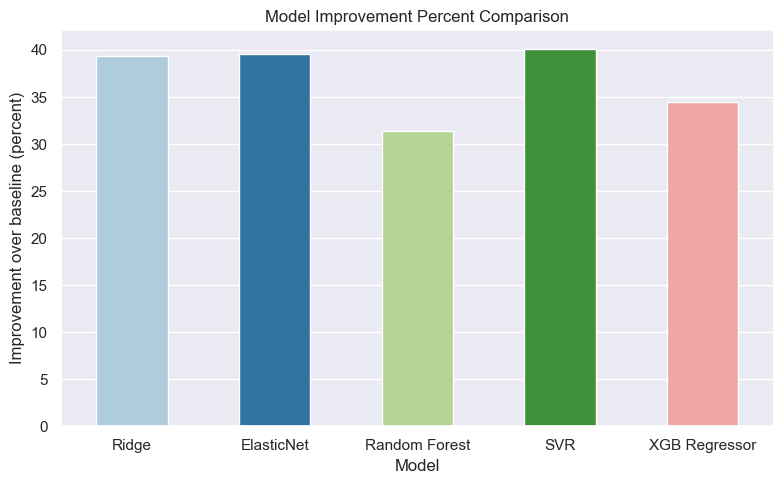

In [ ]:
improv_rows = []

for model_name, res in models_results.items():
    improv_rows.append({
        "Model": model_name,
        "Improvement": res["baseline_improvement_pct"]
    })

improve_df = pd.DataFrame(improv_rows)

plt.figure(figsize=(8, 5))
sns.barplot(data=improve_df, x="Model", y="Improvement", width = 0.5, palette='Paired')

plt.ylabel("Improvement over baseline (percent)")
plt.title("Model Improvement Percent Comparison")
plt.tight_layout()
plt.savefig('model_improvement_percent_comparison.jpg', dpi=300)
plt.show()

/var/folders/rs/40grxw_n255bd354zxdw3rbw0000gn/T/ipykernel_90043/3836846023.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=model_results_df,x='Model',y='Test_RMSE',width=0.4, palette='Paired')


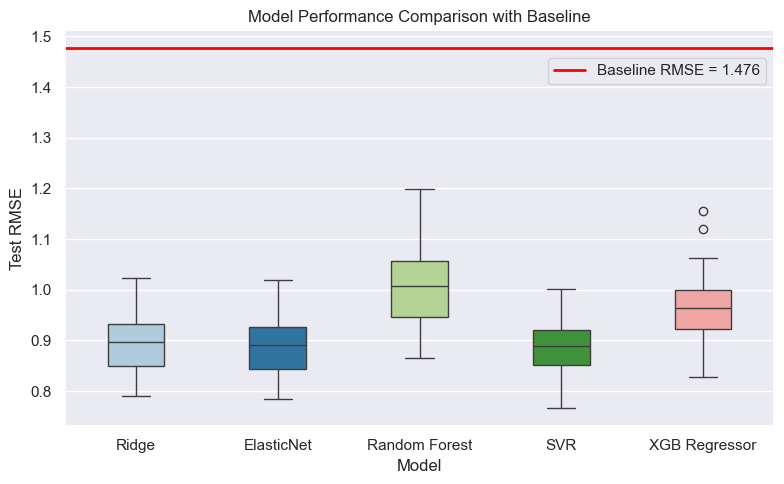

In [ ]:
baseline_global = model_results_df['Baseline_RMSE'].mean()

plt.figure(figsize=(8, 5))

sns.boxplot(data=model_results_df,x='Model',y='Test_RMSE',width=0.4, palette='Paired')

plt.axhline(
    baseline_global,
    color='red',
    linewidth=2,
    label=f'Baseline RMSE = {baseline_global:.3f}'
)

plt.ylabel('Test RMSE')
plt.title('Model Performance Comparison with Baseline')
plt.legend(bbox_to_anchor=(1, 0.95))
plt.tight_layout()
plt.savefig('model_results_boxplot.jpg', dpi=300)
plt.show()

Across all models evaluated under the nested cross validation framework, SVR showed the highest percentage improvement over the baseline predictor. The baseline improvement percentage is calculated by

$$\frac{\text{baseline\_rmse} - \text{model\_rmse}}{\text{baseline\_rmse}}$$


## 5. Interpretation

VR provided the strongest absolute predictive accuracy with the lowest average test RMSE values and highest model improvement percentage. Regarding the best SVR model corresponding to the best test set, we then provide below interpretations: 
- Permutation feature importance: model agnostic and measures how shuffling each feature affects predictive performance, though it can be computationally expensive and sensitive to multicollinearity. 
- SHAP: finer insight by attributing prediction impact to each feature globally and locally in consistent, interpretable units. 
- Partial dependence: shows how the model’s average prediction changes as one feature varies while all others are held fixed. It isolates the marginal effect of a feature and reveals whether its relationship with the target. 


### 5.1 Global Interpretation

#### 5.1.1 Feature Importance

In [110]:
X = df.drop(columns=['name', 'rating']) 
y = df['rating']
groups = df['name']

num_features = ['100g_USD']
cat_features = ['roaster', 'roast', 'loc_country', 'origin','review_date']
text_feature = 'review'

num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
                                  ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])
text_transformer = Pipeline(steps=[('txt', TfidfVectorizer(max_features=500, ngram_range=(1,2), stop_words='english'))])

preprocessor = ColumnTransformer(transformers=[
                                                ('num', num_transformer, num_features),
                                                ('cat', cat_transformer, cat_features),
                                                ('txt', text_transformer, text_feature)])

In [ ]:
from sklearn.svm import SVR

param_grid_svr = {
    'svr__gamma': np.logspace(-3, 3, 5),
    'svr__C': np.logspace(-3, 3, 5),
    'svr__epsilon': [0.1, 0.2, 0.5],
    'svr__kernel': ['linear', 'rbf']
}

test_rmses = []
cv_rmses = []
best_params = []
best_models = []

X_tests, y_tests = [], []

X_test_best, y_test_best = None, None  # for final global importance

for i in range(10):
    gss = GroupShuffleSplit(n_splits=4, train_size=0.8, random_state=42+i)
    print(f"\n=== Iter {i+1} ===")

    for split_idx, (other_idx, test_idx) in enumerate(gss.split(X, y, groups)):
        print(f'    -- Split {split_idx+1} --')

        X_other, y_other = X.iloc[other_idx], y.iloc[other_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        groups_other = groups[other_idx]

        X_tests.append(X_test)
        y_tests.append(y_test)

        gkf = GroupKFold(n_splits=3)
        model = make_pipeline(preprocessor, SVR())

        grid = GridSearchCV(
            estimator=model,
            param_grid=param_grid_svr,
            scoring='neg_root_mean_squared_error',
            cv=gkf,
            verbose=1,
            n_jobs=-1,
            error_score='raise'
        )

        grid.fit(X_other, y_other, groups=groups_other)
        best_model = grid.best_estimator_
        best_param = grid.best_params_

        best_models.append(best_model)
        best_params.append(best_param)
        cv_rmses.append(-grid.best_score_)

        y_test_pred = best_model.predict(X_test)
        test_rmse = root_mean_squared_error(y_test, y_test_pred)
        test_rmses.append(test_rmse)

        print(f'        Test RMSE: {test_rmse:.4f}')

print('\nFinal Summary:')
print(f'    Mean Test RMSE: {np.mean(test_rmses):.4f}')
print(f'    Std Test RMSE: {np.std(test_rmses):.4f}')


=== Iter 1 ===
    -- Split 1 --
Fitting 3 folds for each of 150 candidates, totalling 450 fits
        Test RMSE: 0.8446
    -- Split 2 --
Fitting 3 folds for each of 150 candidates, totalling 450 fits
        Test RMSE: 0.9442
    -- Split 3 --
Fitting 3 folds for each of 150 candidates, totalling 450 fits
        Test RMSE: 0.9276
    -- Split 4 --
Fitting 3 folds for each of 150 candidates, totalling 450 fits
        Test RMSE: 0.8156

=== Iter 2 ===
    -- Split 1 --
Fitting 3 folds for each of 150 candidates, totalling 450 fits
        Test RMSE: 0.9514
    -- Split 2 --
Fitting 3 folds for each of 150 candidates, totalling 450 fits
        Test RMSE: 0.8923
    -- Split 3 --
Fitting 3 folds for each of 150 candidates, totalling 450 fits
        Test RMSE: 0.8812
    -- Split 4 --
Fitting 3 folds for each of 150 candidates, totalling 450 fits
        Test RMSE: 0.9897

=== Iter 3 ===
    -- Split 1 --
Fitting 3 folds for each of 150 candidates, totalling 450 fits
        Test RM

Exception ignored in: <function ResourceTracker.__del__ at 0x11007a020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104ea6020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107a92020>
Traceback (most recent call last

In [44]:
best_index = np.argmin(test_rmses)
best_svr_model = best_models[best_index]
best_X_test = X_tests[best_index]
best_X_test = pd.DataFrame(best_X_test, columns=X.columns)
best_y_test = y_tests[best_index]

In [45]:
import pickle

with open("best_svr_model.pkl", "wb") as f:
    pickle.dump(best_svr_model, f)
    
with open("best_X_test.pkl", "wb") as f:
    pickle.dump(best_X_test, f)

with open("best_y_test.pkl", "wb") as f:
    pickle.dump(best_y_test, f)

In [191]:
import pickle

with open("best_svr_model.pkl", "rb") as f:
    best_svr_model = pickle.load(f)
with open("best_X_test.pkl", "rb") as f:
    best_X_test = pickle.load(f)
with open("best_y_test.pkl", "rb") as f:
    best_y_test = pickle.load(f)

In [132]:
best_X_test

,roaster,roast,loc_country,origin,100g_USD,review_date,review
19,Big Creek Coffee Roasters,Medium-Light,United States,Ethiopia,4.41,November 2017,"Sweet, spice-toned, pungent. Hazelnut, cocoa, ..."
24,Good Folks Coffee,Medium-Light,United States,Kenya,6.47,December 2017,"Intensely sweet, intricately rich. Pink grapef..."
27,Willoughby's Coffee & Tea,Medium-Light,United States,Panama,16.17,December 2017,"Complex, uniquely sweet, tropical. Plumeria, r..."
32,Ka'u Specialty Coffee,Medium-Light,Hawai'i,Hawai'I,13.00,January 2018,"Deeply sweet, delicately zesty, complexly frui..."
37,Chocolate Fish Coffee Roasters,Light,United States,Guatemala,5.00,December 2017,"Richly sweet, high-toned. Maple syrup, orange ..."
...,...,...,...,...,...,...,...
1235,Chromatic Coffee,Medium-Light,United States,El Salvador,9.17,November 2022,"Deeply chocolaty, richly sweet. Dark chocolate..."
1238,Tico Coffee Roasters,Medium-Light,United States,Costa Rica,5.88,November 2022,"Crisp, nutty, sweetly herb-toned. Lemon balm, ..."
1241,El Gran Cafe,Medium-Light,Guatemala,Guatemala,4.70,November 2022,"Crisply sweet, nut-toned. Almond brittle, pie ..."
1243,El Gran Cafe,Medium-Light,Guatemala,Guatemala,2.94,November 2022,"High-toned, enticingly sweet. Black cherry, na..."


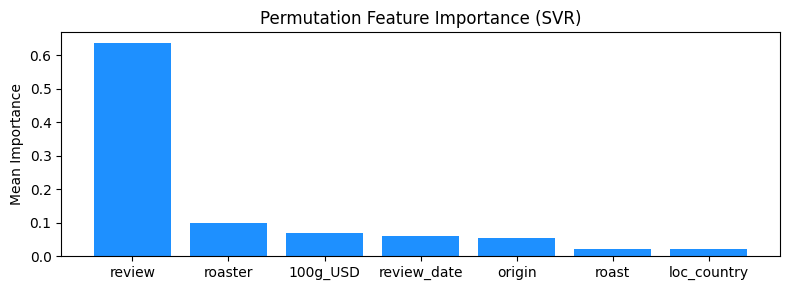

In [39]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_svr_model, best_X_test, best_y_test, n_repeats=10, random_state=42)

importances = result.importances_mean
stds = result.importances_std
indices = np.argsort(importances)[::-1]

feature_names = best_X_test.columns[indices]

plt.figure(figsize=(8, 3))
plt.bar(range(len(importances)), importances[indices], color = 'dodgerblue')
plt.xticks(ticks=range(len(importances)), labels=feature_names)
plt.ylabel("Mean Importance")
plt.title("Permutation Feature Importance (SVR)")
plt.tight_layout()
plt.savefig("permutation_feature_importance_svr_barplot.jpg", dpi=300)
plt.show()

This figure displays the mean importance of features as computed via permutation importance on the best-performing SVR model. The most dominant feature by far is review, which reflects the TF-IDF vectorized textual review content provided by expert tasters. This feature yields the highest drop in model performance when permuted, we can see that the SVR model relies most heavily on the linguistic content of the review when predicting the rating.

**5.1.2 SHAP**

In [192]:
preprocessor = best_svr_model.named_steps['columntransformer']
regressor = best_svr_model.named_steps['svr']

In [193]:
X_test_transformed = preprocessor.transform(best_X_test)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['num__100g_USD', 'cat__roaster_1951 Coffee Company',
       'cat__roaster_1980 CAFE', 'cat__roaster_94 Fresh Coffee',
       'cat__roaster_A.R.C.', 'cat__roaster_AKA Coffee Roasters',
       'cat__roaster_Amavida Coffee Roasters',
       'cat__roaster_Argyle Coffee Roasters',
       'cat__roaster_Atom Coffee Roasters',
       'cat__roaster_Atomic Coffee Roasters',
       "cat__roaster_Augie's Coffee Roasters", 'cat__roaster_Auto Coffee',
       'cat__roaster_BLK & Bold', 'cat__roaster_Ba Yang Coffee',
       'cat__roaster_Baba Java Coffee', 'cat__roaster_Back Home Coffee',
       'cat__roaster_Bargain Cafe',
       'cat__roaster_Barrington Coffee Roasting',
       'cat__roaster_Bassline Coffee', 'cat__roaster_Battlecreek Coffee',
       'cat__roaster_Battlecreek Coffee Roasters',
       'cat__roaster_Beanfruit Coffee Co.', "cat__roaster_Ben's Beans",
       'cat__roaster_Big Creek Coffee Roasters',
       'cat__roaster_Big Island Coffee Roasters',
       'cat__roaster_Big Should

In [190]:
explainer = shap.KernelExplainer(model=regressor.predict, data=X_test_transformed)
explainer.expected_value

Using 247 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


93.24995761999253

In [ ]:
shap_values= explainer.shap_values(X_test_transformed)
with open("shap_values_sum.pkl", "wb") as f:
    pickle.dump(np.array(shap_values), f)

  0%|          | 0/247 [00:00<?, ?it/s]

In [159]:
import pickle

with open("shap_values_sum.pkl", "rb") as f:
    shap_values = pickle.load(f)

/var/folders/rs/40grxw_n255bd354zxdw3rbw0000gn/T/ipykernel_40443/2366427738.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_transformed, max_display=10, feature_names=feature_names)


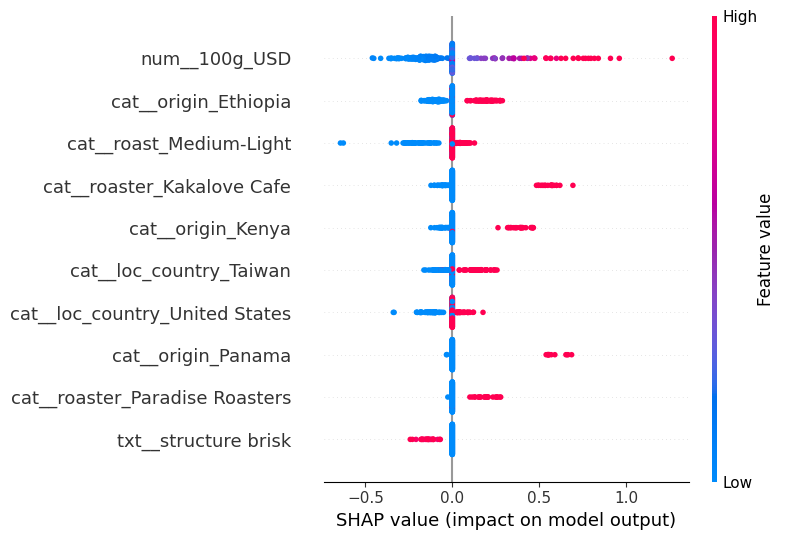

In [160]:
np.random.seed(42)
shap.summary_plot(shap_values, X_test_transformed, max_display=10, feature_names=feature_names)

**5.1.3 Partial Dependence Plots**


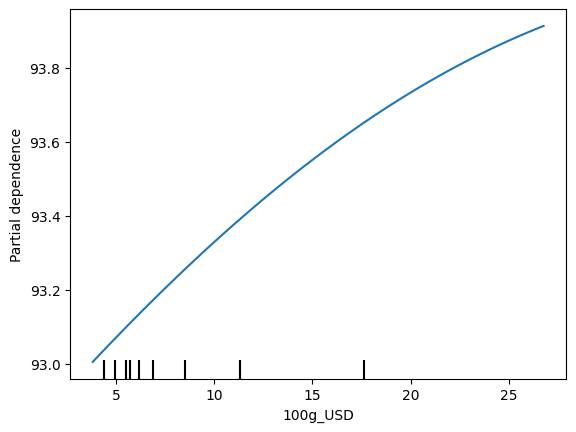

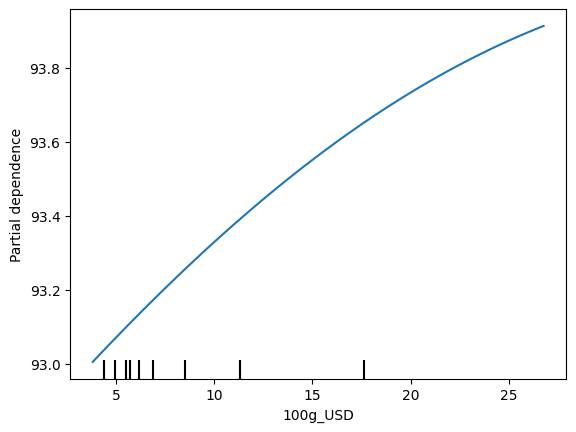

In [146]:
feature_to_plot = ['100g_USD']
PartialDependenceDisplay.from_estimator(best_svr_model,best_X_test,feature_to_plot)
plt.show()


Figure 12 provides the partial dependence curve for 100g_USD dune the best SVR model, it shows a clear positive relationship between price and rating score by coding all other features at their observed values and varying only 100g_USD, although  dependence reflects association, it is not causality, our SVR model has learned that high priced coffees tend to receive higher scores in the data, but this does not imply that raising the price of a specific coffee would directly cause its review score to increase.


**5.1.4 Local SHAP Explanation**

<Figure size 2000x600 with 0 Axes>

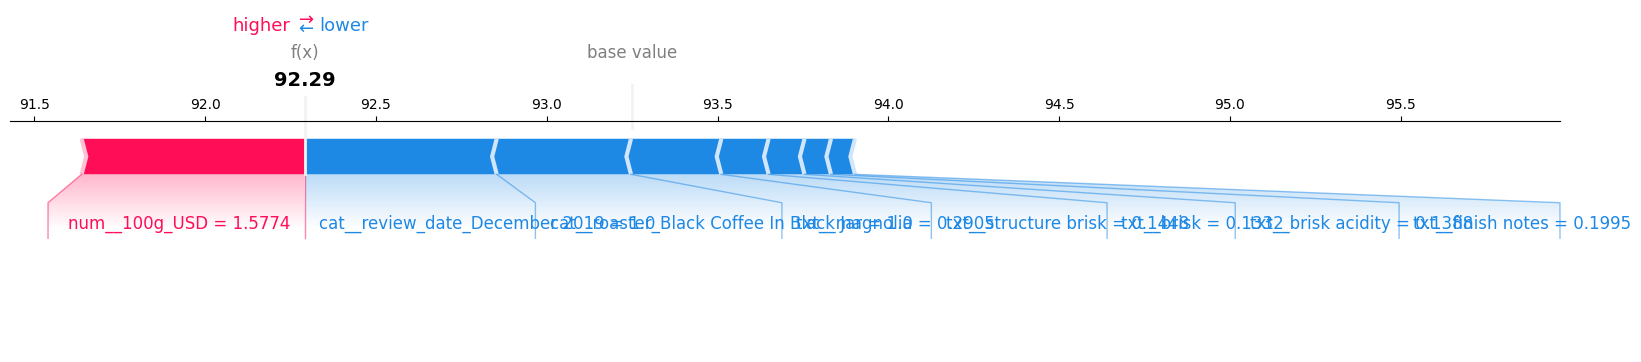

<Figure size 2000x600 with 0 Axes>

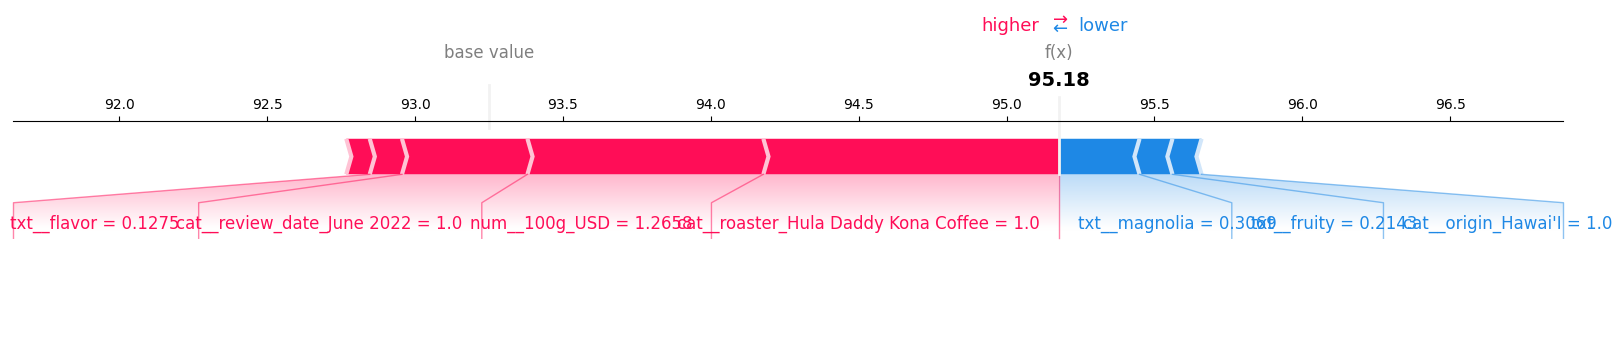

In [311]:
def plot_filtered_local_shap(i, shap_values, X_test_transformed, feature_names, explainer,active_only=True, k=10, save_path=None, figsize=(20, 6), dpi=400):
    x_val = np.round(X_test_transformed[i], 4)
    shap_val = shap_values[i]

    if active_only:
        active_mask = (x_val != 0)
        shap_val = shap_val[active_mask]
        x_val = x_val[active_mask]
        filtered_feature_names = np.array(feature_names)[active_mask]
    else:
        filtered_feature_names = feature_names

    topk_idx = np.argsort(np.abs(shap_val))[::-1][:k]

    plt.figure(figsize=figsize) 

    shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_val[topk_idx],
        features=x_val[topk_idx],
        feature_names=[filtered_feature_names[j] for j in topk_idx],
        matplotlib=True,
        show=True 
    )

    plt.title(f"Local SHAP Plot for Instance {i}", fontsize=14)

    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', pad_inches=0.1)
    plt.close()

plot_filtered_local_shap(
    79, shap_values, X_test_transformed, feature_names, explainer,
    k=8, save_path="local_shap_79.jpg"
)

plot_filtered_local_shap(
    215, shap_values, X_test_transformed, feature_names, explainer,
    k=10, save_path="local_shap_215.jpg"
)

## 6. Outcome

The SVR model outperforms the baseline and the other tested models, yet several aspects of the project can be strengthened.

- The SHAP analysis highlights textual features such as ‘structure brisk’ is informative. Since TF-IDF cannot capture word order or contextual nuance, it struggles with phrases like “not good but expensive” versus “good, not expensive.” Incorporating more advanced NLP representations, such as contextual embeddings, may better capture sentiment and improve model performance.
- Most samples cluster in the 85–90 rating range, and high-priced items dominate. More data from lower rating and lower price segments would help the model learn the full price–quality landscape and improve fairness across roasters and regions.
- The dataset lacks key coffee quality predictors. Future data collection could include processing methods (washed, natural, dry) known to affect taste, botanical varieties (e.g., Gesha, Bourbon) tied to quality and price, altitude which is standard quality indicators in coffee cupping.
- One hot encoding of categorical feature like loc_country, roaster and origin leads to high dimensional sparse features. Possible improvements include target encoding, feature hashing or dimensionality reduction, while monitoring interpretability.